In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os
from scipy.stats import ortho_group

In [2]:
from main import weighted_l2, decode, PSNR, plot_data, load_ecg, load_train_ecg, load_test_ecg, create_pulse
max_signal_length = 100 # used in load_train_ecg and load_test_ecg to keep an integer multiple of patch_size number of samples  

In [3]:
# default values
# cnt is the number of plots to be saved for each (n_components, n_train, patch_size) tuple 
n_train, n_test, n_components, cnt = 10000, 1000, 5, 5
n_init, d, to_train, use_mat = 5, 30, True, False # d is the patch size

# for pulse
num_peaks = d//10
peak_width = 10

folder_name = 'results/n_components=%d,n_train=%d,patch_size=%d/' % (n_components, n_train, d)

In [4]:
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        # k = (d//3) * 2 # something lesser than d
        # W = np.random.rand(d,k)
        # S = (W @ W.transpose()) + np.diag(np.random.rand(1,d) * 0.01)
        # S = np.diag(1/np.sqrt(np.diag(S))) @ S @ np.diag(1/np.sqrt(np.diag(S)))
        # ans.append(S)
        Q = ortho_group.rvs(d)
        decay = 0.47*(1 + np.random.random())
        eps = 1e-8
        U = np.ones(d,) * (np.random.rand() * 20) + 600
        for j in range(1,d):
            U[j] = max((U[j-1] * decay) + (np.random.rand() * 0.01), eps)
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return np.array(ans)

In [5]:
gen_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

gen_model.weights_ = np.random.rand(n_components,)
gen_model.weights_ /= np.sum(gen_model.weights_)

gen_model.means_ = np.random.rand(n_components, d) * 80
gen_model.covariances_ = generate_covariance_matrices(n_components, d)

[0.12060454 0.30924935 0.13455037 0.08712456 0.34847118]
(5,)
(5, 30)
(5, 30, 30)


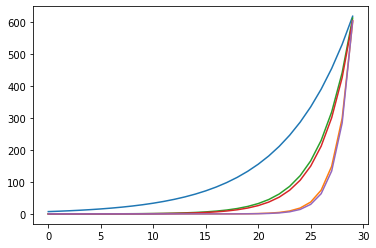

In [7]:
print(gen_model.weights_) # check if no single component gets majority of the weight 
print(gen_model.weights_.shape)
print(gen_model.means_.shape)
print(gen_model.covariances_.shape)

# sanity check of covariance matrix
for i in range(n_components):
    # asserting checks if matrix is positive definite
    assert(np.linalg.det(gen_model.covariances_[i,:,:]) > 0)
    plt.plot(np.linalg.eigvalsh(gen_model.covariances_[i,:,:]))
    
plt.show()

In [8]:
train_data,_ = gen_model.sample(n_train)
train_data.shape

(10000, 30)

In [9]:
# here one assumption is that we know the number of components, however this will have to be varied
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
model.fit(train_data)

if os.path.isdir(folder_name):
    for f in os.listdir(folder_name):
        if not os.path.isdir(folder_name + f):
            os.remove(folder_name + f)
else:
    os.makedirs(folder_name)

# Save the model as a pickle in a file
joblib.dump(model, folder_name + 'model.pkl')

Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True


['results/n_components=5,n_train=10000,patch_size=30/model.pkl']

In [10]:
test_data,_ = gen_model.sample(n_test)
A_ = np.random.binomial(1, 0.5, size=(d, d))

ms = [d*(i+1)//10 for i in range(10)]
psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
val_err, err_std = [], []

for m in tqdm(ms):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    reconstruction = np.empty(test_data.shape)
    patch_err = []
    cnt1 = cnt
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
        # cs example
        if cnt1 > 0:
            plt.plot(x, label='Original', color = "C0")
            plt.plot(x_hat, label='Reconstructed', color = "C1")
            plt.legend()
            plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
            plt.close()
            cnt1 -= 1
        reconstruction[j] = x_hat
    val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    psnr.append(val)
    psnr_min.append(min_val)
    psnr_max.append(max_val)
    psnr_std.append(std_val)
    val_err.append(np.mean(patch_err))
    err_std.append(np.std(patch_err))

print(psnr)
print(psnr_std)
print(val_err)
print(err_std)
plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


[25.999525000200137, 30.83806456379114, 37.85566009075814, 41.61932995492521, 46.94576812718074, 49.10995470593371, 51.4342502558854, 54.31944525830915, 56.461075473877216, 59.44163888262445]
[10.034062596788484, 9.512486884832597, 9.434099034588536, 8.98883170334721, 10.245104723513547, 10.656259134382658, 11.185546329850439, 11.264277939073406, 11.151450742882027, 11.04317446540054]
[39.11626472719549, 25.090670938203417, 16.35006025210759, 8.43718914043935, 5.410176015147976, 5.8950824643989534, 6.2800560332462485, 5.1172235779423, 5.188890834964929, 4.379498615137685]
[55.536012105830686, 41.27591162349714, 37.09172233556476, 13.621875873180716, 9.721641826790808, 10.455606717707965, 11.29736815144718, 9.48651824845266, 11.044836794845377, 10.183588141013665]


# The following section would be to detect anomalies in the y domain
- we can use val error which is the mean of cross val errors for each measurent length
- let us detect drift based on the following condition

If 10 or more consecutive samples lie outside $E[e_{cv}] + 0.5V[e_{cv}]$ we will conclude that there is a drift in the generating distribution

10it [01:58, 11.80s/it]


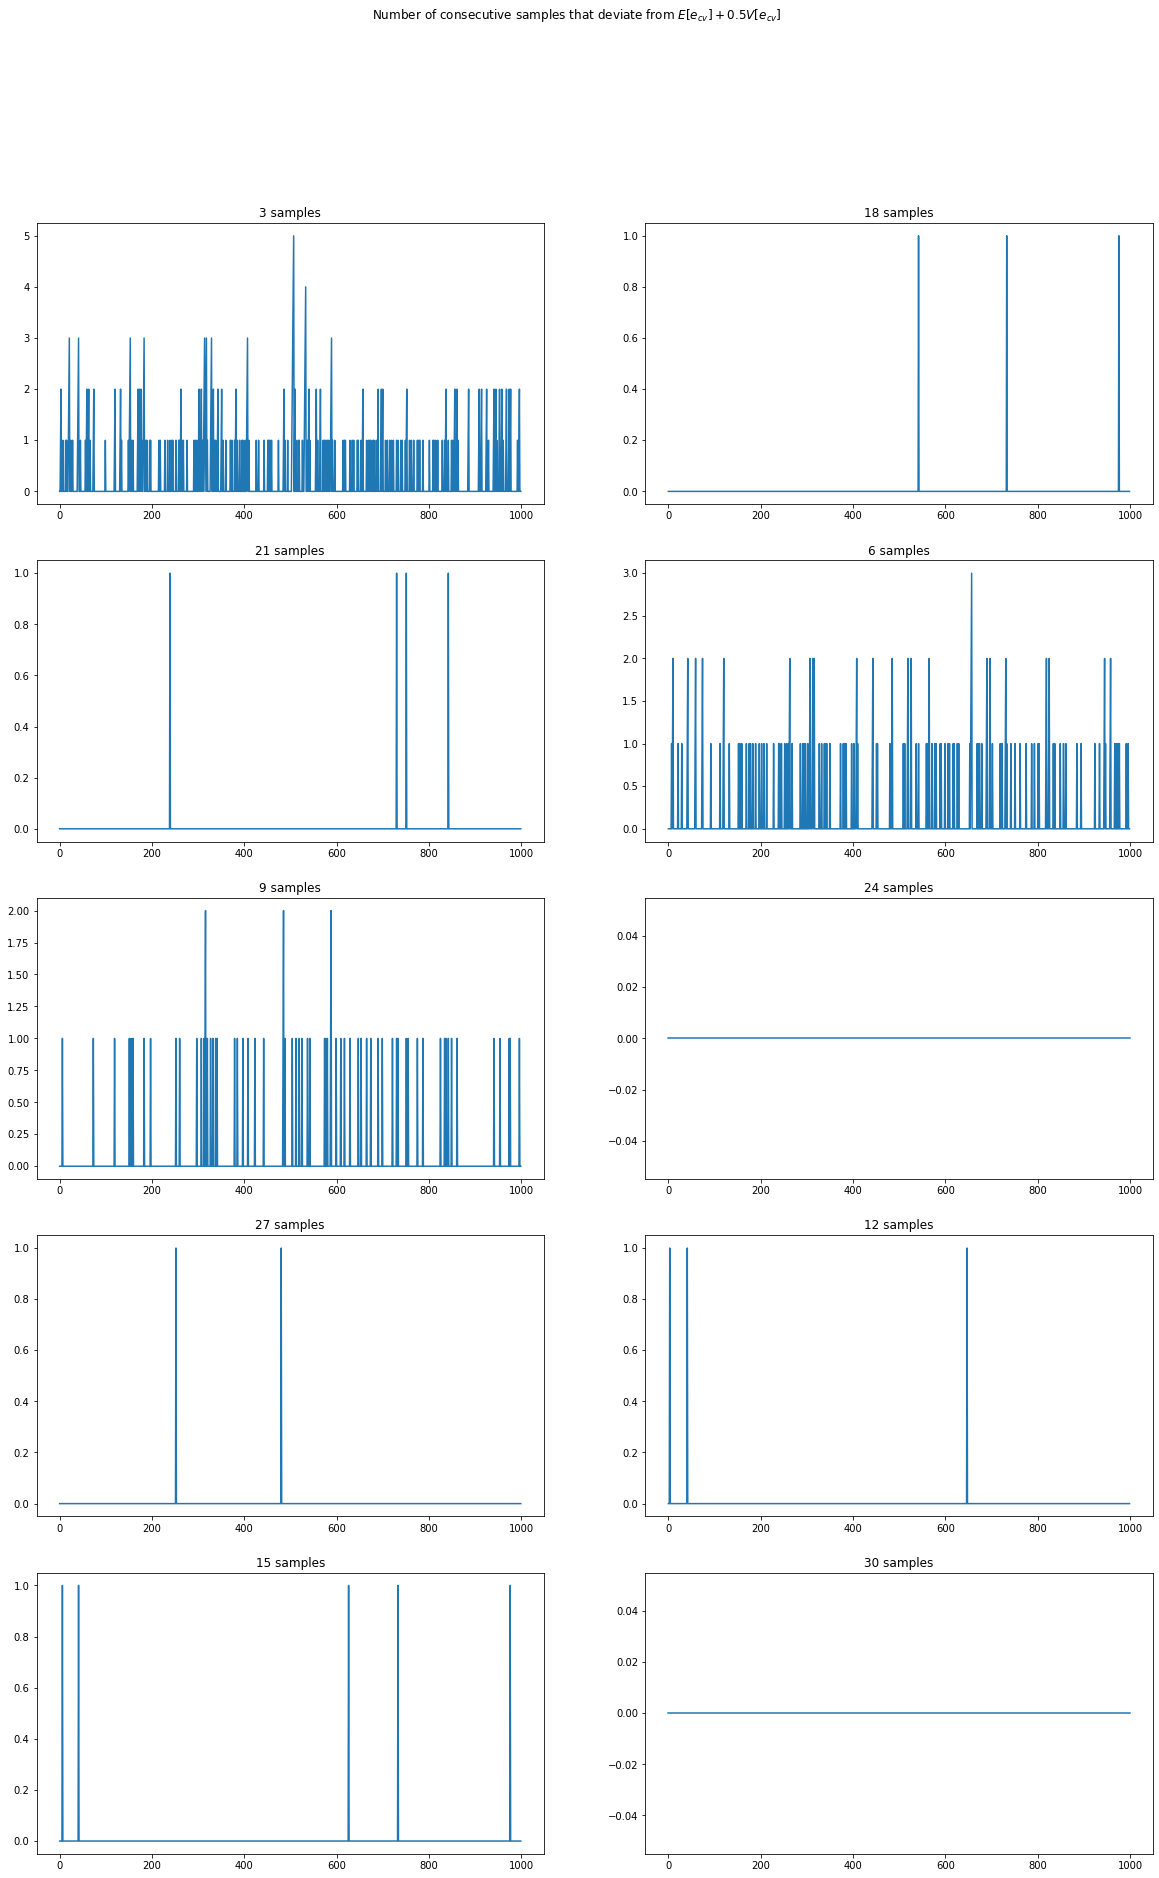

In [11]:
test_data,_ = gen_model.sample(n_test)
np.random.shuffle(test_data)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of consecutive samples that deviate from $E[e_{cv}] + 0.5V[e_{cv}]$")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    dev_counts = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (val_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            dev_counts.append(deviation_count)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(dev_counts)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

# Observation
We observe that unless the number of measurements is too low (10%), it is very rare that the number of consecutive samples that deviate from <br> $E[e_{cv}] + 0.5V[e_{cv}]$ would be greater than 20. Hence, we can use this as a criteria to detect drift <br>
The following section intends to introduce a drift in the generating distribution intentionally to check whether our criteria was correct

In [12]:
# introduction on drift in the generating distribution
np.random.seed(42)
drift_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

drift_model.weights_ = gen_model.weights_
drift_model.means_ = gen_model.means_ + (gen_model.means_ * np.random.choice([-1,1]) * (0.2 + 0.2*(np.random.rand())))
drift_model.covariances_ = generate_covariance_matrices(n_components, d)

10it [01:14,  7.46s/it]


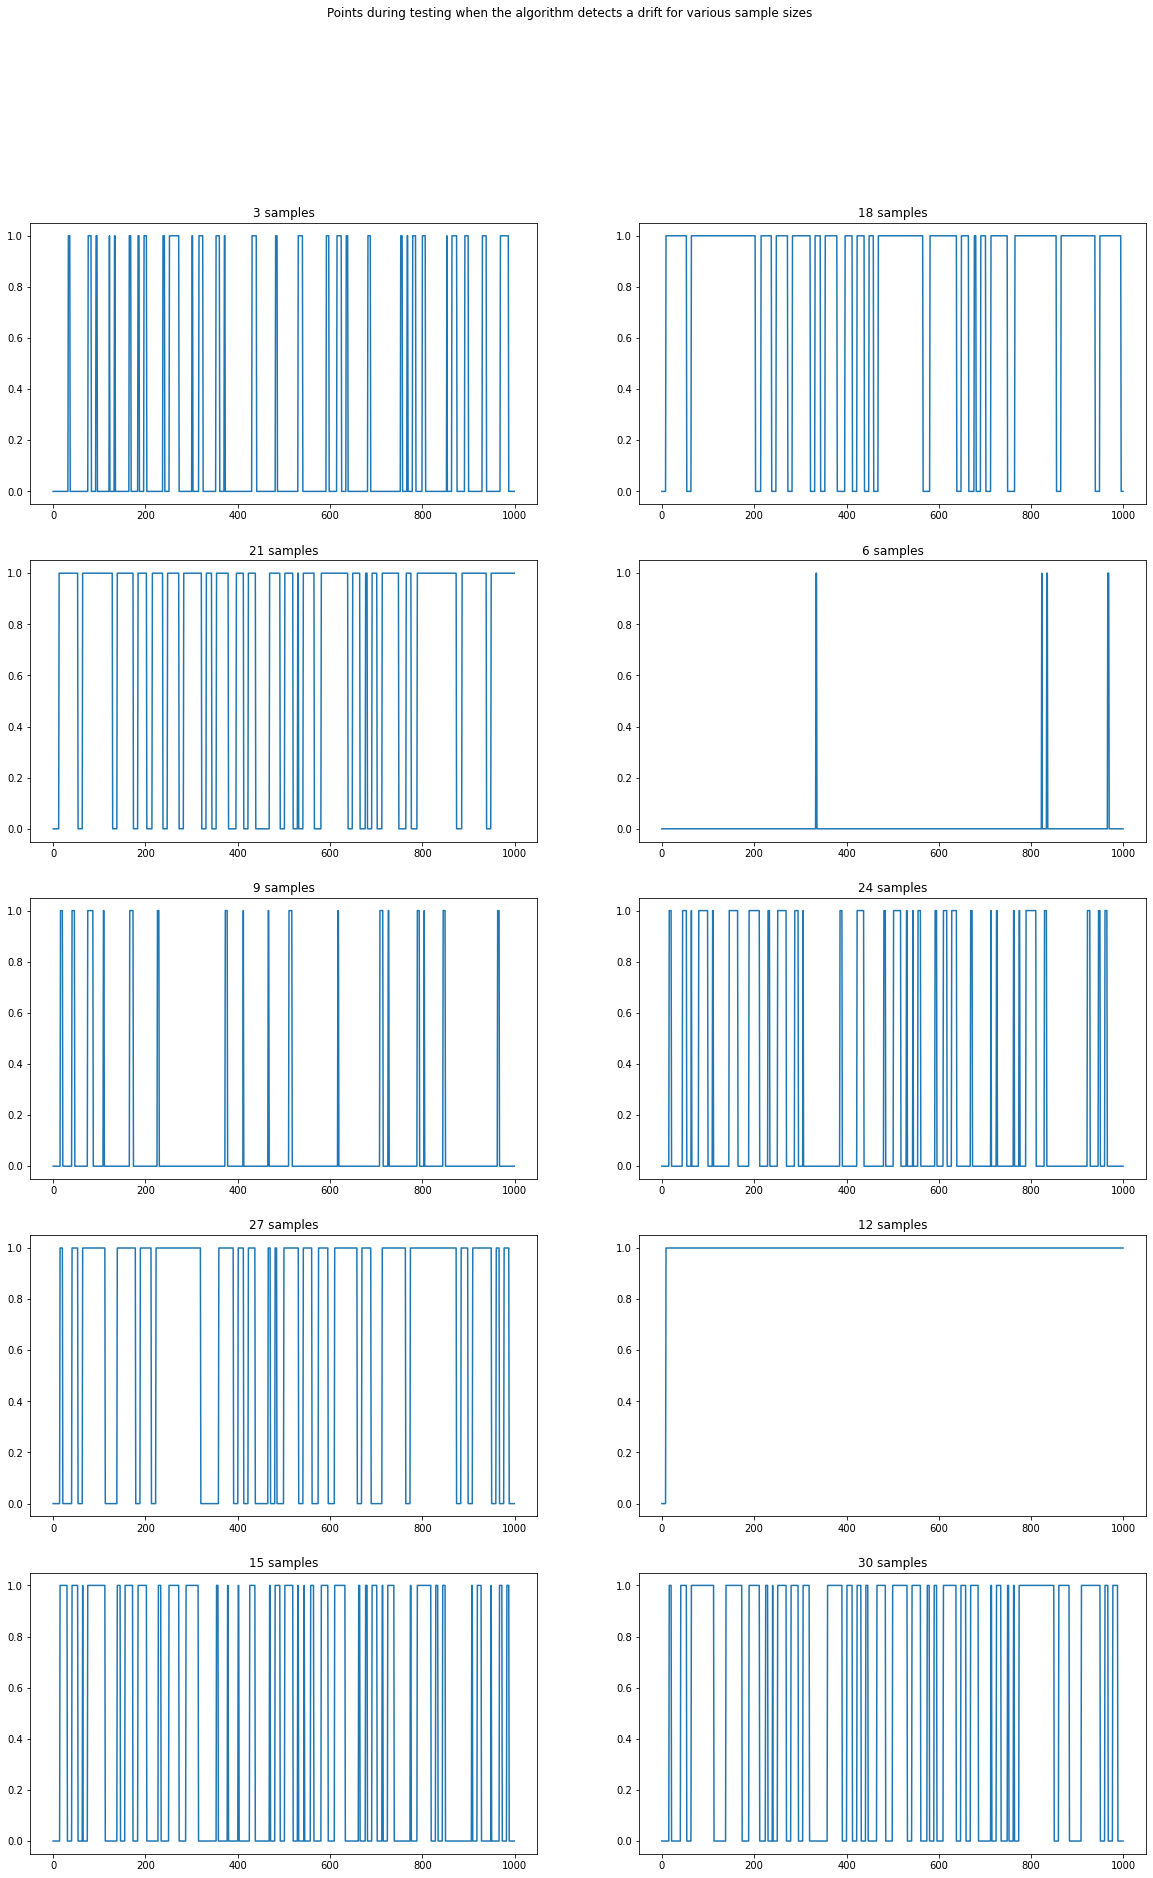

In [13]:
test_data,_ = drift_model.sample(n_test)
np.random.shuffle(test_data)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    flagged = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (val_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            if(deviation_count >= 10):
                flagged.append(1)
            else:
                flagged.append(0)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(flagged)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

Hence we observe that we almost always are able to detect a drift with the given method

In [22]:
# loading aluminium panel data
folder_name_1 = "data/aluminium_data/BASELINE_1(Healthy)/Data_with3dprinter/Data_with_dso/"
folder_name_2 = "data/aluminium_data/rivet_hole_temp/Data_with_dso/"
paths_1 = [folder_name_1 + f"Temp{x}/P13.csv" for x in range(20,70,5)]
paths_2 = [folder_name_2 + f"Temp{x}/P13.csv" for x in range(20,70,5)]
# lets only do 13 right now for different temperatures as this will show max variation in case of damages and undamaged measurements

In [42]:
from sklearn.model_selection import train_test_split

def train_GMM_to_data(db, temp,  patch_size = 100, n_components = 10, n_init = 10):
    """
    Takes the entire dataset and splits it into train and test sets. Trains on the training set 
    and returns the model and test set
    """
    d = patch_size
    entries = np.array(db["output"])
    # using overlapping patches for training
    train_data = np.empty((entries.shape[0] - d + 1, d))
    for i in range(entries.shape[0] - d + 1):
        train_data[i] = entries[i:i+d]

    train_data, test_data = train_test_split(train_data, test_size=0.5)
    print(f"train data samples = {train_data.shape[0]}")
    print(f"test data samples = {test_data.shape[0]}")
    # now make test_data non-overlapping
    test_data = np.array([test_data[i, :] for i in range(0, test_data.shape[0], d)] )
    print(f"test data samples (non-overlapping) = {test_data.shape[0]}")

    n_train = train_data.shape[0]
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/' % (temp, n_components, n_train, d)

    model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
    model.fit(train_data)

    if os.path.isdir(folder_name):
        for f in os.listdir(folder_name):
            if not os.path.isdir(folder_name + f):
                os.remove(folder_name + f)
    else:
        os.makedirs(folder_name)


    # finding threshold empirically using training data itself
    A_ = np.random.binomial(1, 0.5, size=(d, d))
    ms = [d*(i+1)//10 for i in range(10)]
    psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
    val_err, err_std = [], []

    for m in tqdm(ms):
        if use_mat:
            A = np.load(folder_name + 'mat/%d.npy' % m)
        else:
            A = A_[:m, :]
        mm = (m*4)//5
        reconstruction = np.empty(test_data.shape)
        patch_err = []
        for j in range(len(test_data)):
            x = test_data[j]
            x_hat = np.zeros(x.shape)
            for i in range(x.shape[0]//d):
                y = A @ x[i*d:(i+1)*d]
                x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
                patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
            # cs example
            reconstruction[j] = x_hat
        val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
        psnr.append(val)
        psnr_min.append(min_val)
        psnr_max.append(max_val)
        psnr_std.append(std_val)
        val_err.append(np.mean(patch_err))
        err_std.append(np.std(patch_err))

    print(psnr)
    print(psnr_std)
    print(val_err)
    print(err_std)
    # Save the model as a pickle in a file
    joblib.dump(model, folder_name + 'model.pkl')
    return (model, n_train, test_data, A_, np.array(val_err) + (0.5 * np.array(err_std)))

In [43]:
def get_rivet_data(db, temp, patch_size = 100):
    d = patch_size
    entries = np.array(db["output"])
    # using overlapping patches for training
    # test_data = np.empty((entries.shape[0]//d, d))
    print(test_data.shape)
    for i in range(entries.shape[0]//d):
        test_data[i] = entries[i*d:(i+1)*d]

    print(f"test data size = {test_data.shape[0]}")
    # now make test_data non-overlapping
    return test_data

In [50]:
def reconstruct_test_data(model, A_, test_data, temp, patch_size, n_components, n_train, thresholds, clean):
    d = patch_size
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/%s/' % (temp, n_components, n_train, d, clean)
    if os.path.isdir(folder_name):
        for f in os.listdir(folder_name):
            if not os.path.isdir(folder_name + f):
                os.remove(folder_name + f)
    else:
        os.makedirs(folder_name)

    ms = [d*(i+1)//10 for i in range(10)]
    psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
    val_err, err_std = [], []

    fig1, ax1 = plt.subplots(5, 2, figsize=(20, 30))
    fig1.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")

    for f,m in tqdm(enumerate(ms)):
        if use_mat:
            A = np.load(folder_name + 'mat/%d.npy' % m)
        else:
            A = A_[:m, :]
        mm = (m*4)//5
        reconstruction = np.empty(test_data.shape)
        patch_err = []
        cnt1 = cnt
        deviations = 0
        flagged = []
        deviation_count = []
        for j in range(len(test_data)):
            x = test_data[j]
            x_hat = np.zeros(x.shape)
            for i in range(x.shape[0]//d):
                y = A @ x[i*d:(i+1)*d]
                x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
                patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
                if(patch_err[-1] > thresholds[f]):
                    deviations += 1
                else:
                    deviations = 0
                if(deviations >= 5):
                    flagged.append(1)
                else:
                    flagged.append(0)
                deviation_count.append(deviations)
            # cs example
            if cnt1 > 0:
                plt.figure()
                plt.plot(x, label='Original', color = "C0")
                plt.plot(x_hat, label='Reconstructed', color = "C1")
                plt.legend()
                plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
                plt.close()
                cnt1 -= 1
            reconstruction[j] = x_hat
        val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
        psnr.append(val)
        psnr_min.append(min_val)
        psnr_max.append(max_val)
        psnr_std.append(std_val)
        val_err.append(np.mean(patch_err))
        err_std.append(np.std(patch_err))
        if clean == "clean":
            ax1[f%5][f%2].plot(deviation_count)
        else:
            ax1[f%5][f%2].plot(flagged)
        ax1[f%5][f%2].set_title('%d samples' % m)

    plt.show()
    print(psnr)
    print(psnr_std)
    print(val_err)
    print(err_std)
    plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
    plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

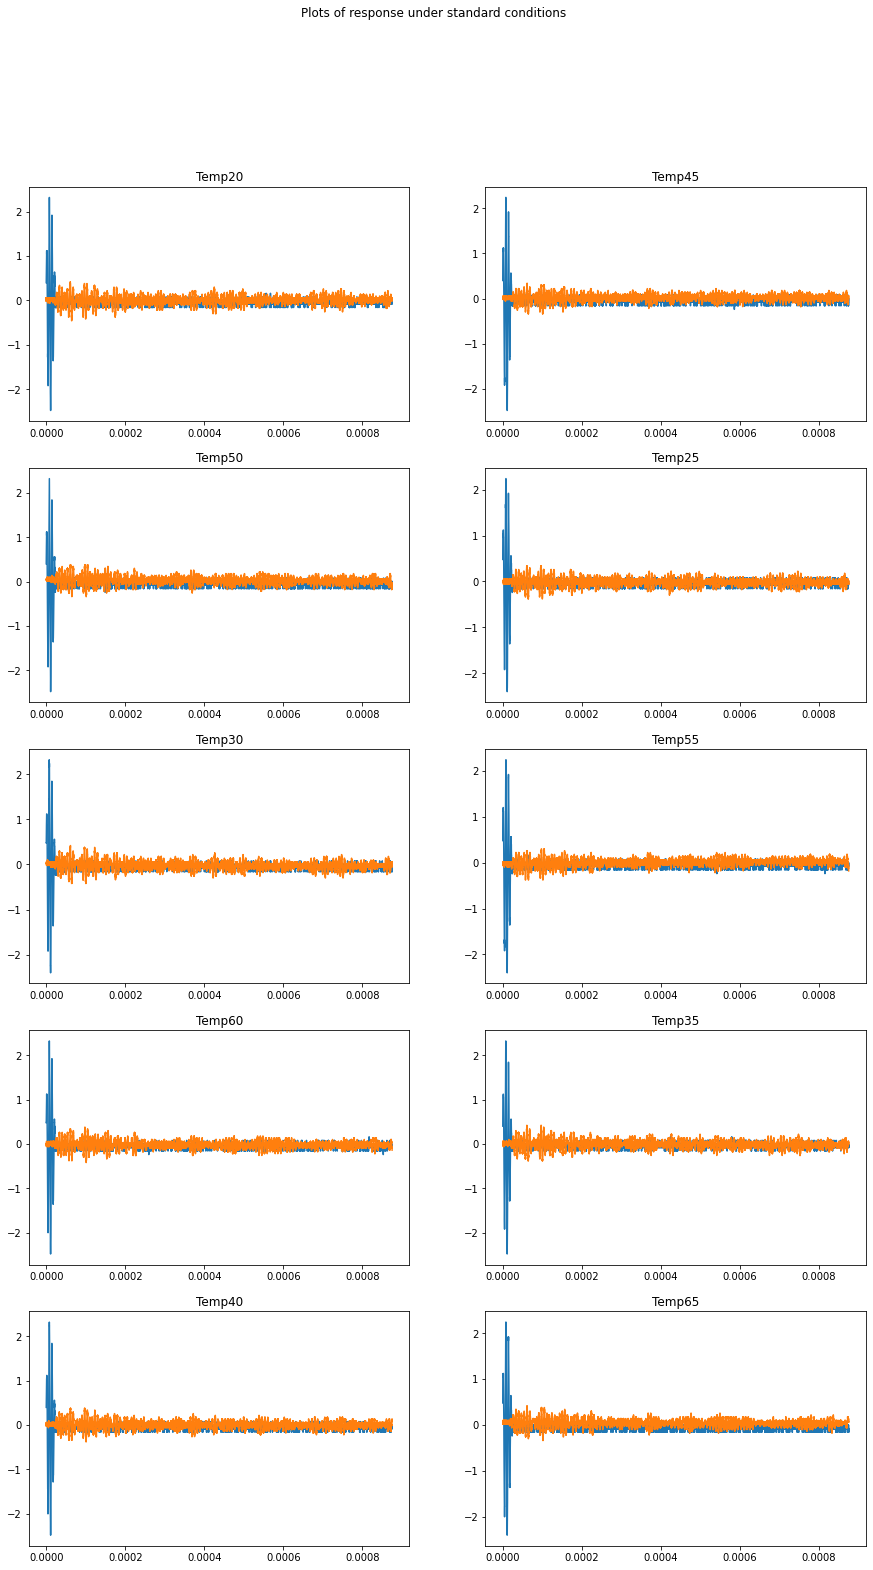

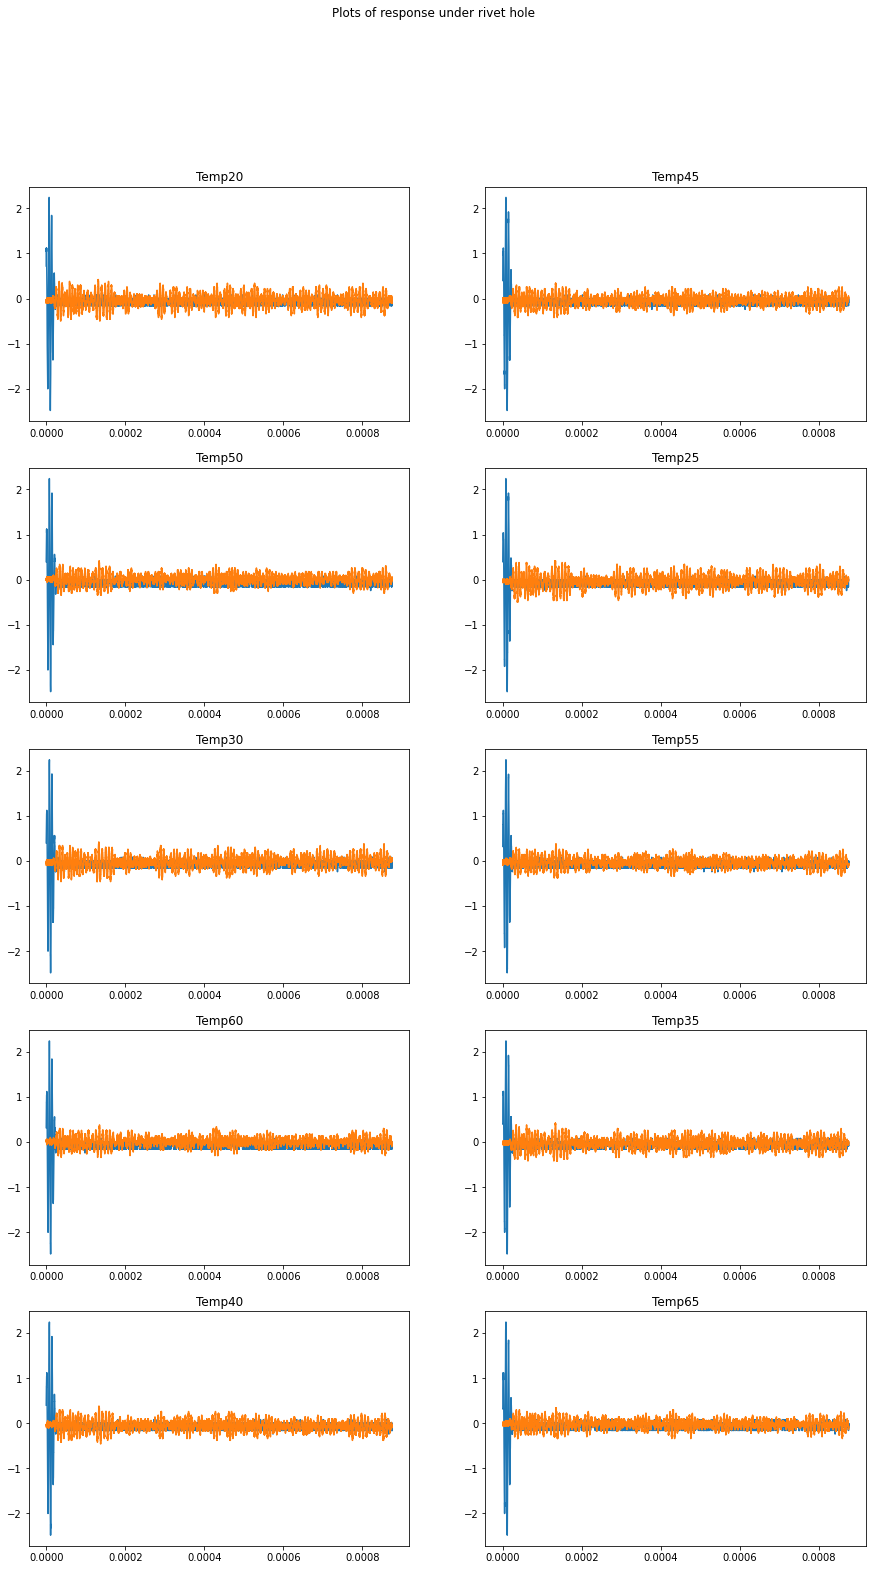

train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


[26.765040562513878, 27.612939680906866, 28.13477798156728, 28.658547508779126, 29.072807371661682, 29.569732802766023, 30.27007026561266, 30.99118597271995, 32.264312615076776, 33.567564392640506]
[0.9776940092058647, 0.7682113083439515, 0.5973252522514071, 0.6075717149492328, 0.6319277926724978, 0.8404864299228612, 0.7375489745341497, 0.8195983525792305, 1.1072230766090403, 1.3817117740252118]
[0.24251232177552895, 0.2595932353714336, 0.31370893901296104, 0.32814787722419037, 0.35454072257262975, 0.37036846907408005, 0.35522971185903285, 0.37375403153876224, 0.3499059224602463, 0.31720260354798485]
[0.11973767470012243, 0.09479344484910225, 0.07913359416011433, 0.09241749674346152, 0.0780202263110784, 0.07679062026671808, 0.07029304630478701, 0.0731970404837603, 0.07378440170198462, 0.07068924239973419]


10it [00:39,  3.92s/it]


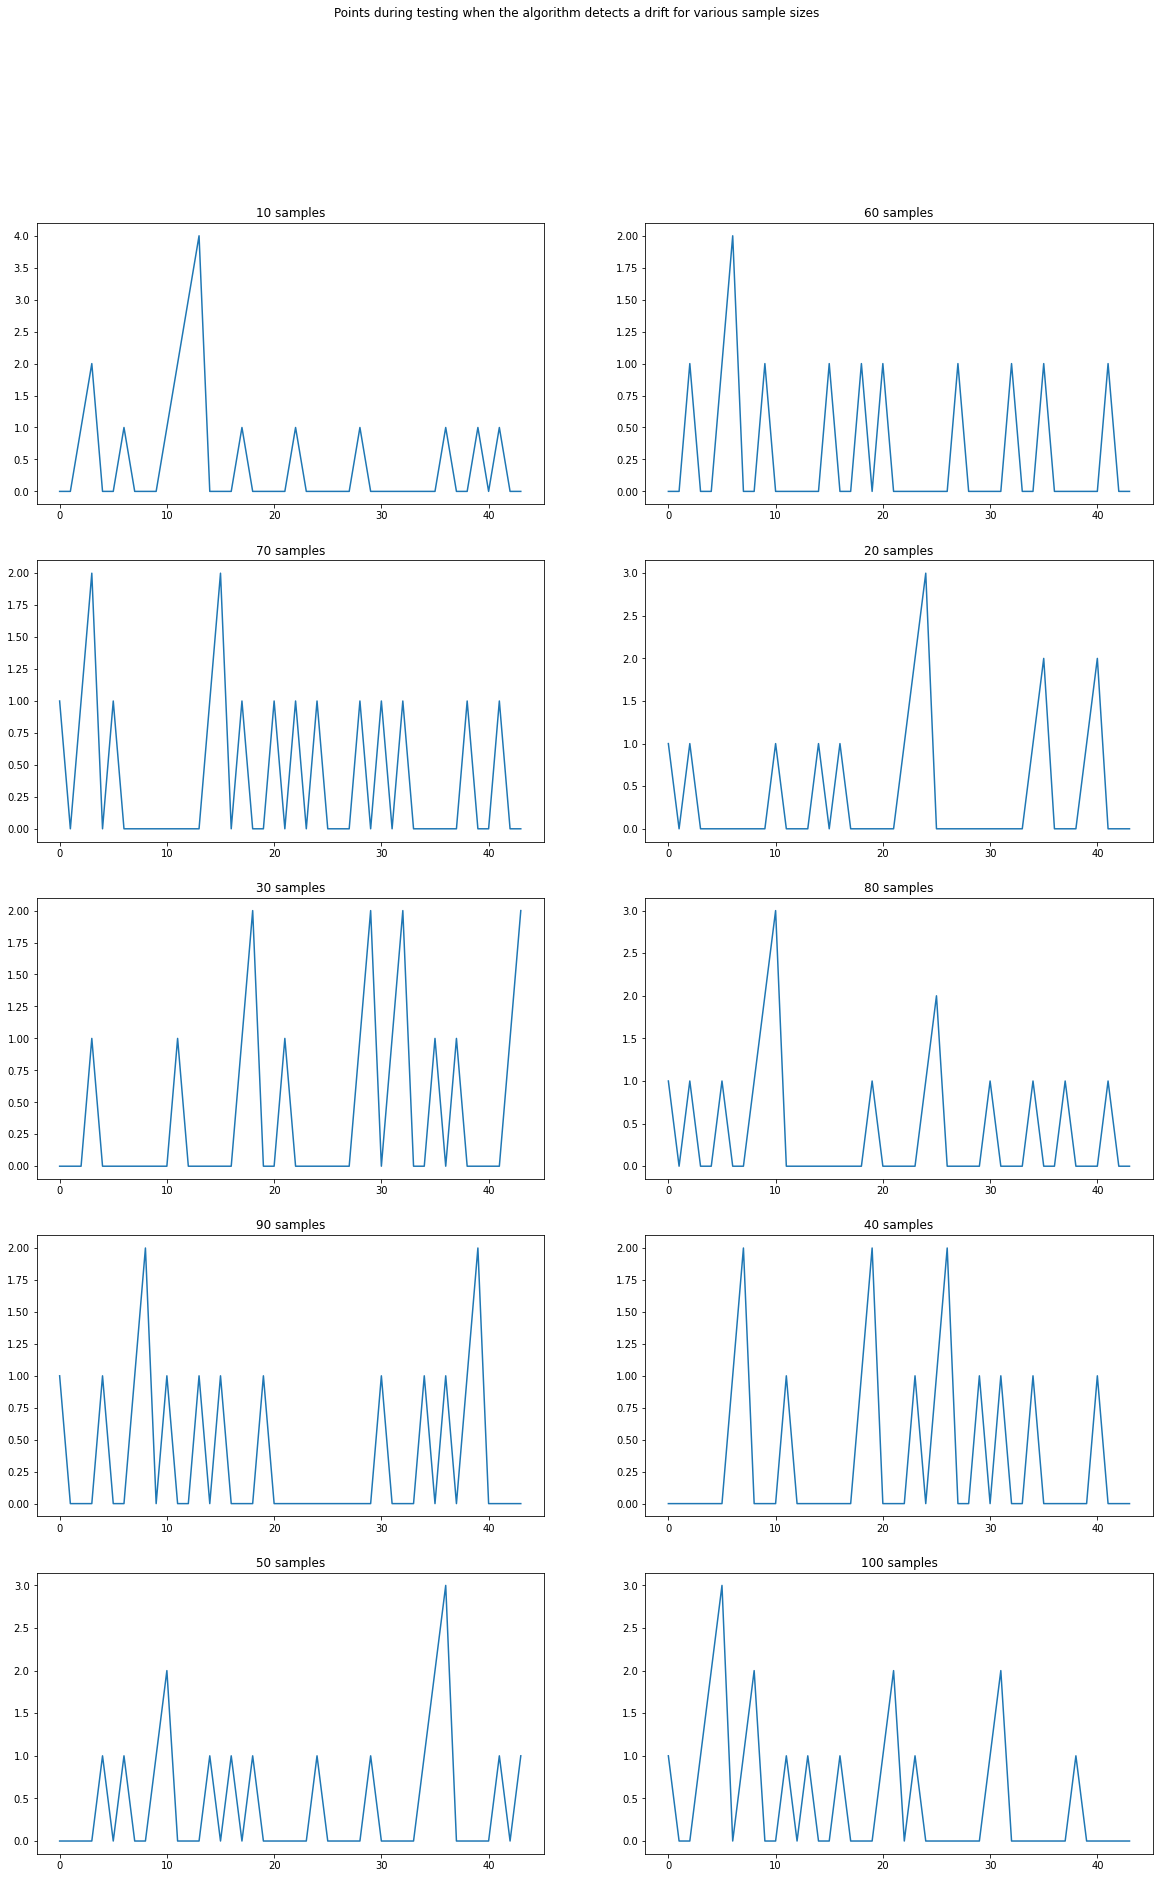

[26.765040562513878, 27.612939680906866, 28.13477798156728, 28.658547508779126, 29.072807371661682, 29.569732802766023, 30.27007026561266, 30.99118597271995, 32.264312615076776, 33.567564392640506]
[0.9776940092058647, 0.7682113083439515, 0.5973252522514071, 0.6075717149492328, 0.6319277926724978, 0.8404864299228612, 0.7375489745341497, 0.8195983525792305, 1.1072230766090403, 1.3817117740252118]
[0.24251232177552895, 0.2595932353714336, 0.31370893901296104, 0.32814787722419037, 0.35454072257262975, 0.37036846907408005, 0.35522971185903285, 0.37375403153876224, 0.3499059224602463, 0.31720260354798485]
[0.11973767470012243, 0.09479344484910225, 0.07913359416011433, 0.09241749674346152, 0.0780202263110784, 0.07679062026671808, 0.07029304630478701, 0.0731970404837603, 0.07378440170198462, 0.07068924239973419]
(87, 100)
test data size = 87


10it [01:03,  6.39s/it]


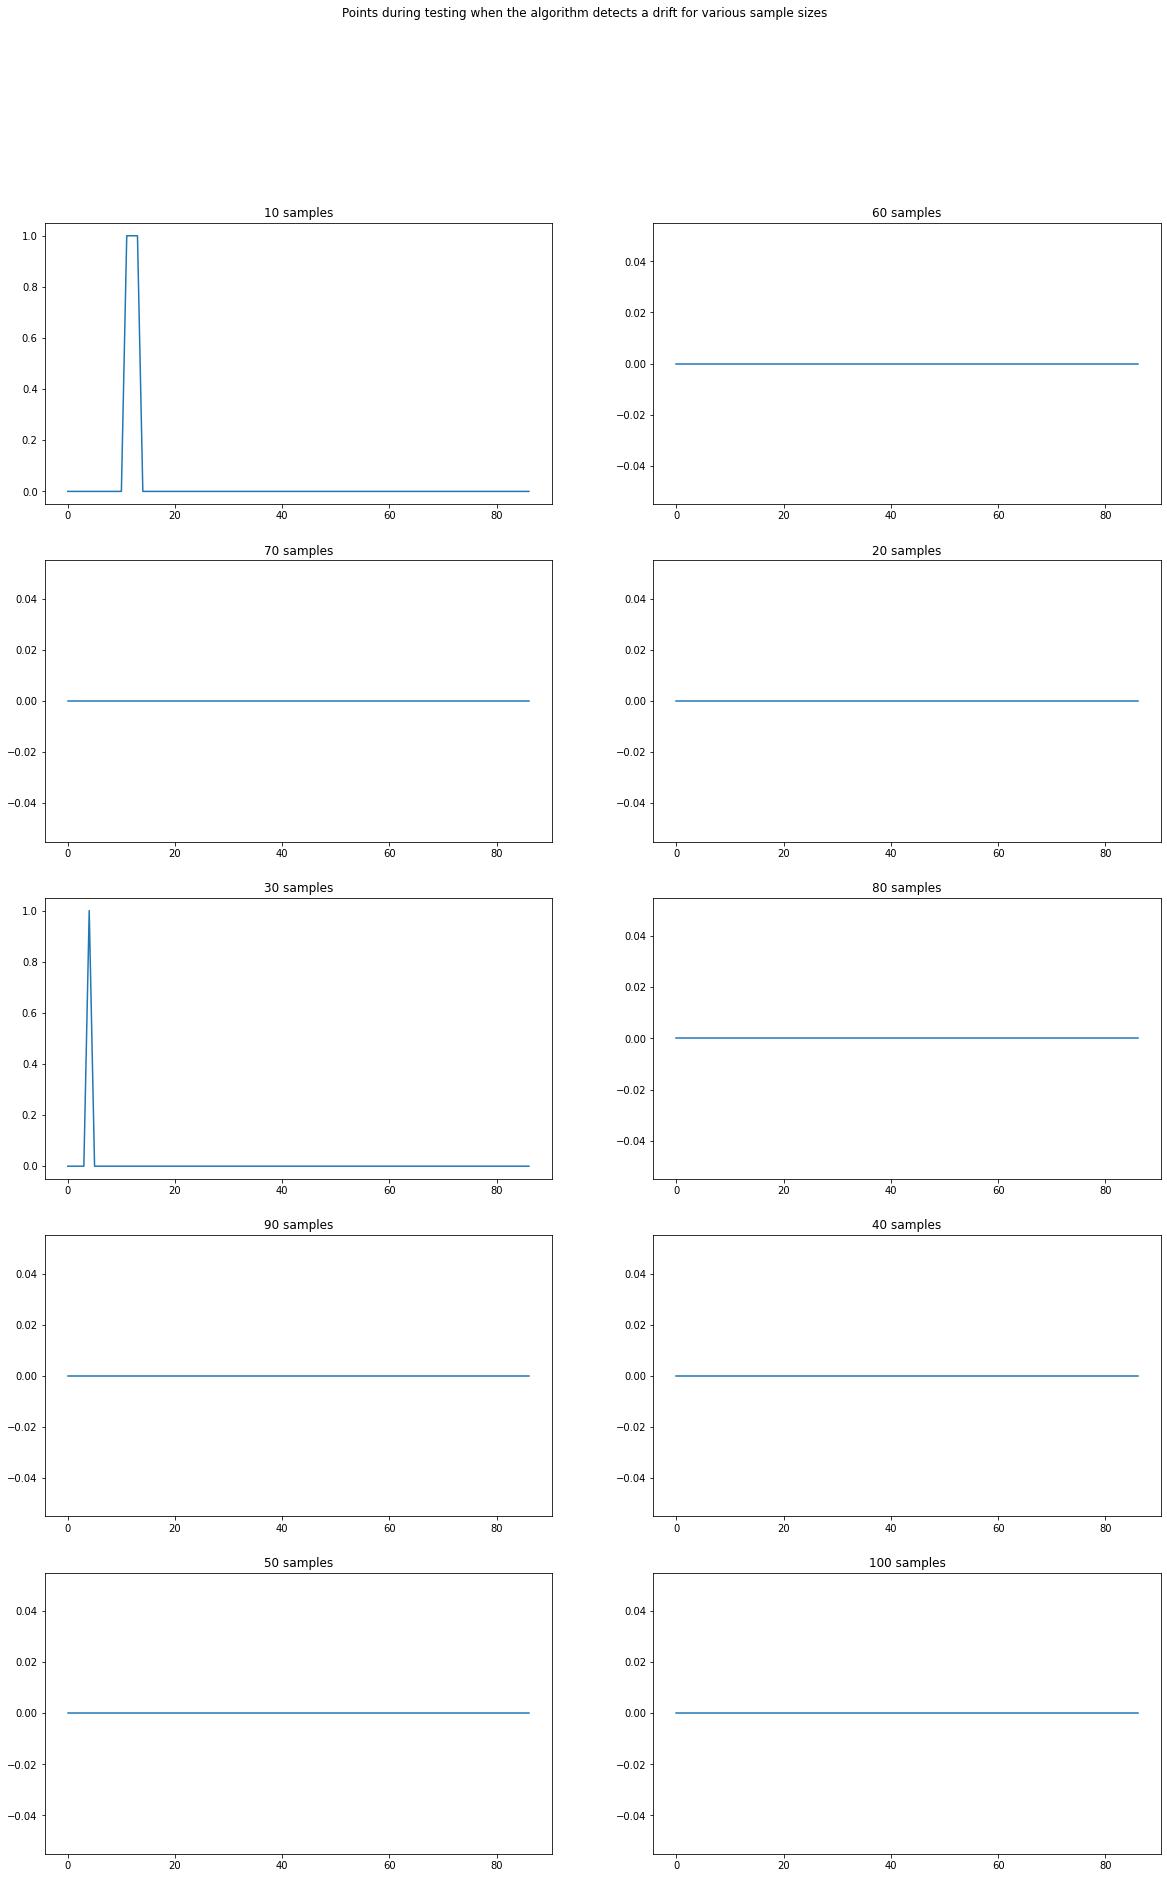

[28.91574847550197, 30.1066414230549, 30.858447906573108, 31.458446966448644, 32.00718360405706, 32.5197672302201, 33.25378638459659, 34.12736844874008, 35.23901028465211, 36.632899808476765]
[1.375631390569513, 0.9434488066499787, 0.8500110604127056, 0.7702900448894695, 0.8055067605849764, 0.890121797086852, 0.9070243885950394, 0.9760107287947849, 1.1332429641675654, 1.306984420845366]
[0.28783654186333374, 0.29547382054863847, 0.3319979762338783, 0.3466297637578477, 0.36274940738689865, 0.3910011661450468, 0.37449674181364967, 0.36832763740302116, 0.3542642844515779, 0.3233499682790765]
[0.13970002561027062, 0.1172097823856897, 0.10558775994021141, 0.08849683670020196, 0.08020214655060669, 0.10062985113166238, 0.08080600707880328, 0.08030877759589981, 0.06677285837371731, 0.06516600151486202]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converg

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


[27.601077278685093, 28.24835624233984, 29.07513992771484, 29.494898556647456, 30.133433919703045, 30.71864709768323, 31.49250516621016, 32.29269750621424, 33.39707507530645, 34.98166734709609]
[1.2314115444946956, 1.248554538561902, 0.8245245309447337, 0.8494518724934189, 0.7982653313776872, 0.872470328871509, 1.0100150184152787, 1.0738512217276692, 1.1187953395993997, 1.365022619666488]
[0.17946389916364225, 0.26478519180358556, 0.3123461655610164, 0.36829073212416363, 0.3394050557238873, 0.35373866685544225, 0.3597097917268649, 0.34552873351733465, 0.3139094713288972, 0.2758158177811015]
[0.09274070179072612, 0.09248334744133367, 0.08780446429413213, 0.08825296098651884, 0.0738626065685058, 0.07784003264692331, 0.07978618156452555, 0.08096714149328431, 0.06279029937143284, 0.07100625837727736]


10it [00:45,  4.53s/it]


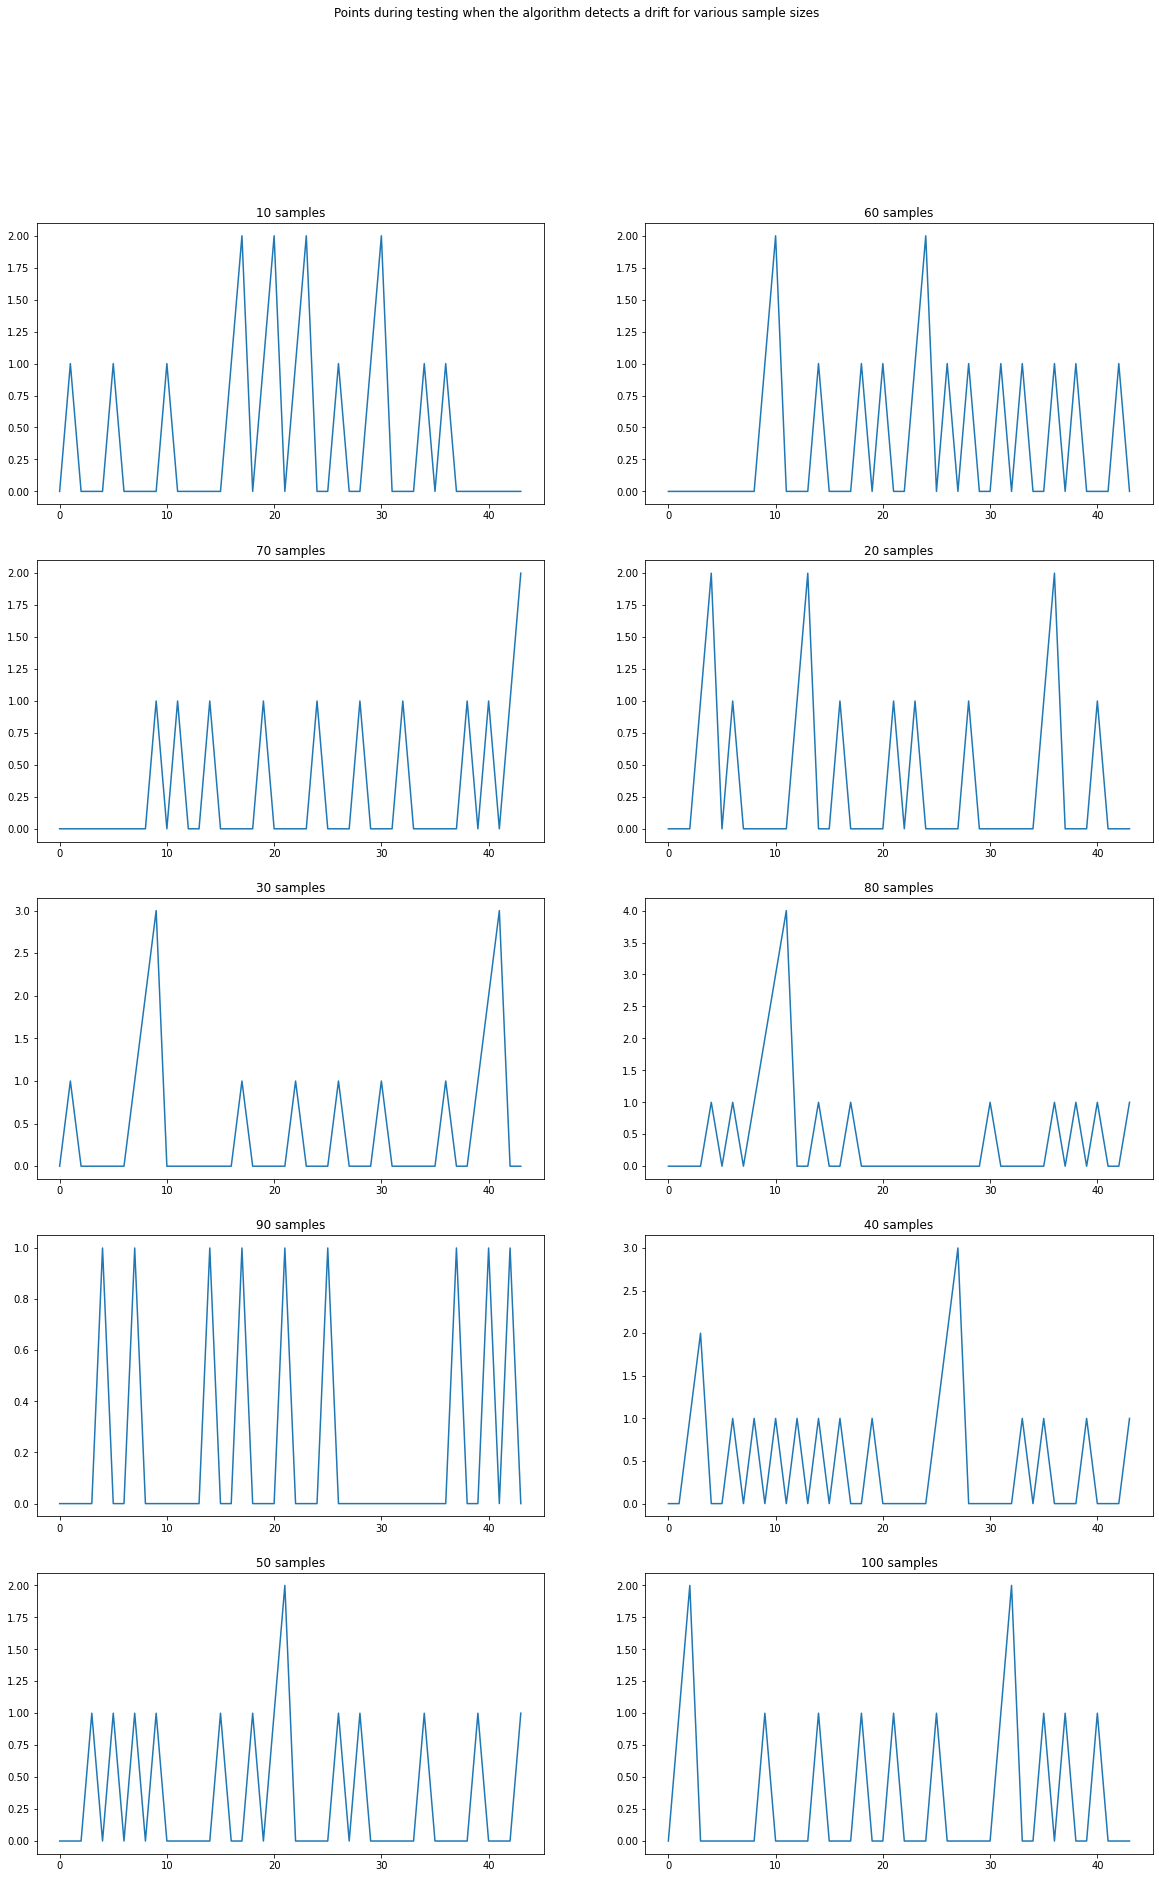

[27.601077278685093, 28.24835624233984, 29.07513992771484, 29.494898556647456, 30.133433919703045, 30.71864709768323, 31.49250516621016, 32.29269750621424, 33.39707507530645, 34.98166734709609]
[1.2314115444946956, 1.248554538561902, 0.8245245309447337, 0.8494518724934189, 0.7982653313776872, 0.872470328871509, 1.0100150184152787, 1.0738512217276692, 1.1187953395993997, 1.365022619666488]
[0.17946389916364225, 0.26478519180358556, 0.3123461655610164, 0.36829073212416363, 0.3394050557238873, 0.35373866685544225, 0.3597097917268649, 0.34552873351733465, 0.3139094713288972, 0.2758158177811015]
[0.09274070179072612, 0.09248334744133367, 0.08780446429413213, 0.08825296098651884, 0.0738626065685058, 0.07784003264692331, 0.07978618156452555, 0.08096714149328431, 0.06279029937143284, 0.07100625837727736]
(87, 100)
test data size = 87


10it [01:09,  6.97s/it]


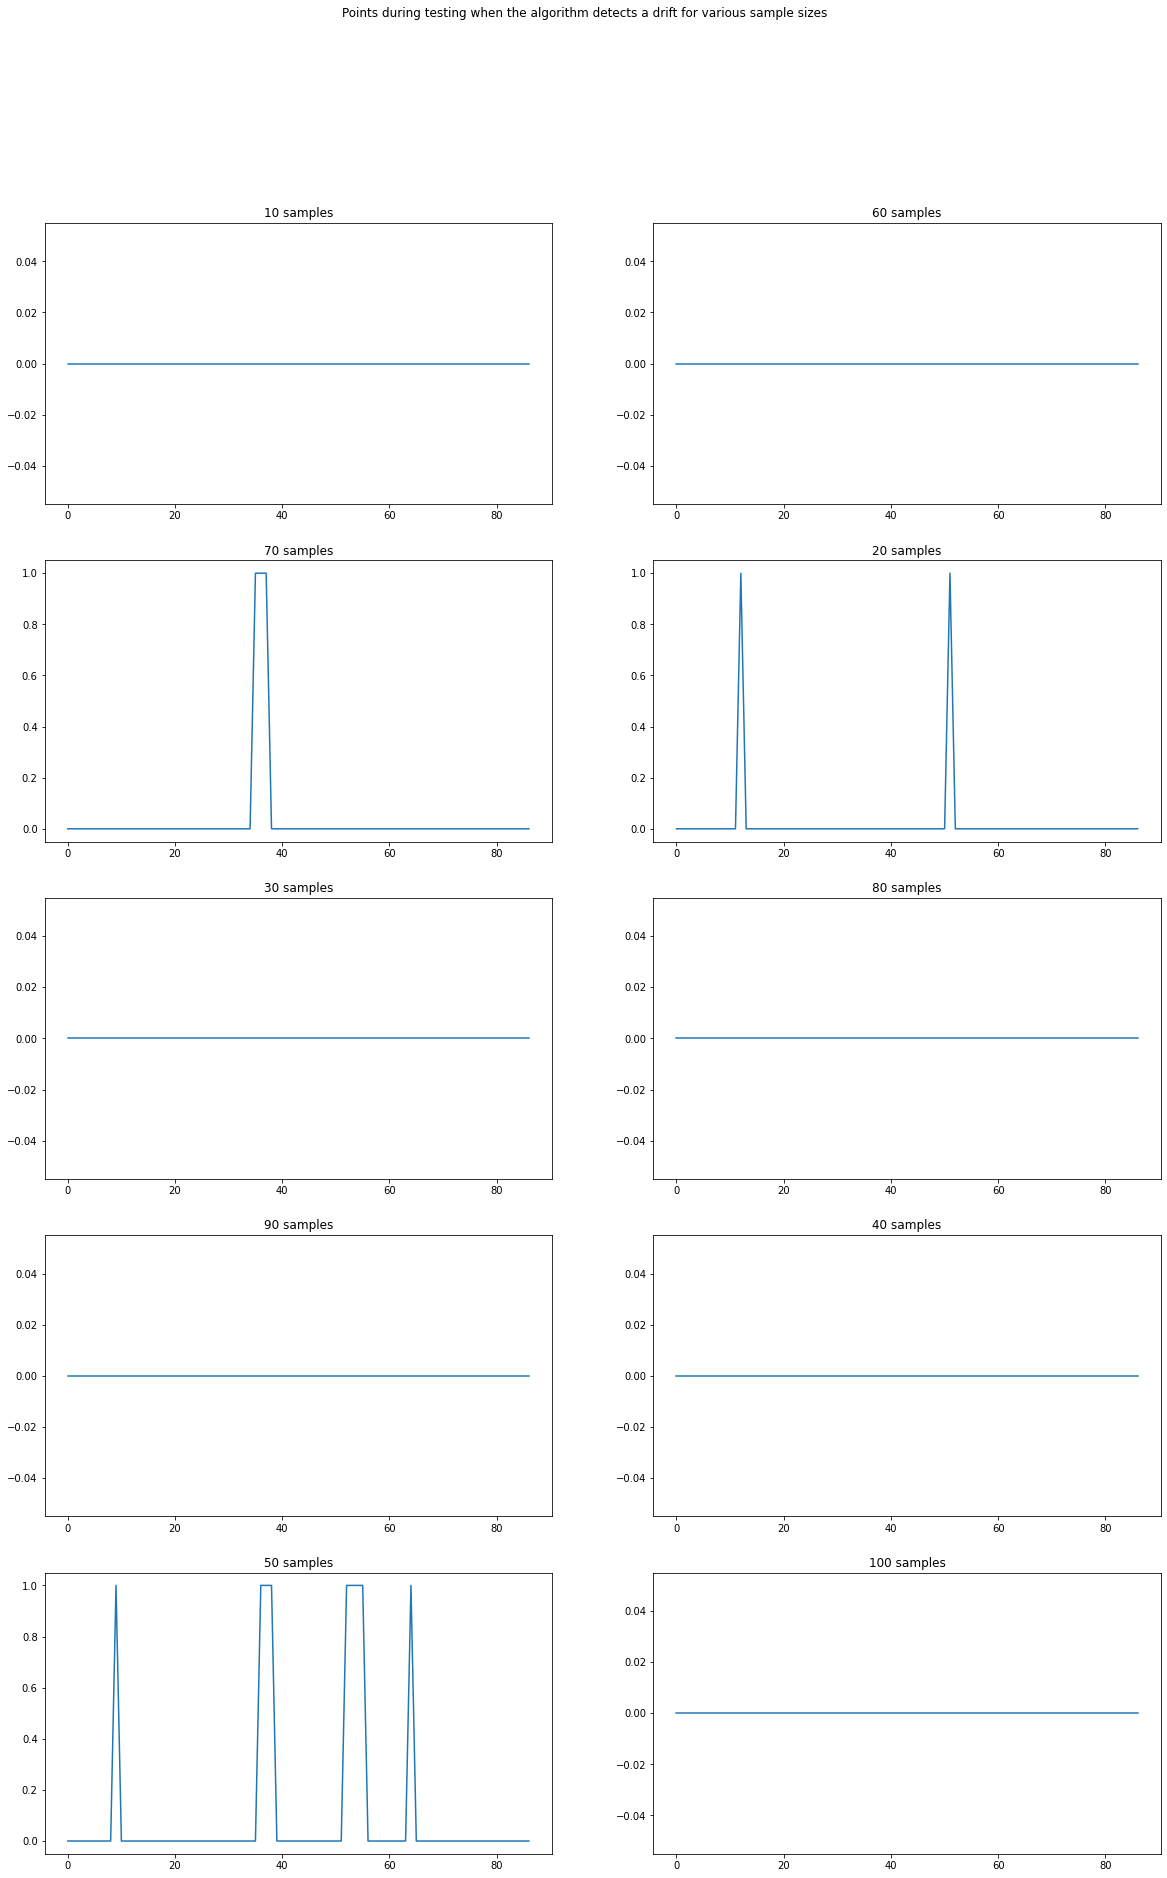

[27.385007227124447, 29.462878283320695, 30.70981113476838, 31.21901342900671, 31.86716370232321, 32.55563704367801, 33.29783490593435, 34.12509903951705, 35.19846656763239, 36.58929770998295]
[2.185640737051333, 1.5239912683571937, 0.9668692982103585, 1.0197921315605447, 0.9036865370011582, 0.9932744325191146, 1.1116877135382104, 1.2390581967483227, 1.3006439144269872, 1.5711254182610206]
[0.21992091067426567, 0.3022945709587222, 0.3077664852351025, 0.359385902704338, 0.39329224532317897, 0.37100355533383694, 0.3733356826071416, 0.3630978244646423, 0.3220218012737255, 0.2789286525724178]
[0.12363991929254829, 0.1240975101378648, 0.09720622475591352, 0.09508899639705275, 0.08577574035553504, 0.0968802096622228, 0.08566671390818062, 0.07792040778817173, 0.07113689955103833, 0.07258654841344787]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initiali

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[26.406119385068333, 28.25948138567005, 28.964992991905195, 29.347624520390692, 30.017908479189547, 30.63707529661275, 31.40299044818304, 32.07580094549423, 33.19535317364256, 34.67911018438494]
[1.5292088282621867, 0.9882796025744851, 0.7435212084909308, 0.8466852297094367, 0.7827070091683217, 0.9488765791806005, 0.9104097487104835, 0.9740720573197552, 1.0420947218037293, 1.3358971906980197]
[0.28284502337715894, 0.2639069134642682, 0.2868699771972129, 0.33183698585427707, 0.36438127413088, 0.3983144369088287, 0.3484898264817528, 0.34481242424649156, 0.33158554826300696, 0.3052806855234962]
[0.16491438293984859, 0.09491252207679884, 0.0868762929298296, 0.09399701146236687, 0.07601065931023496, 0.08334863875376859, 0.08706267060809568, 0.08495057585668873, 0.0707756230204044, 0.06472124782081422]


10it [00:25,  2.57s/it]


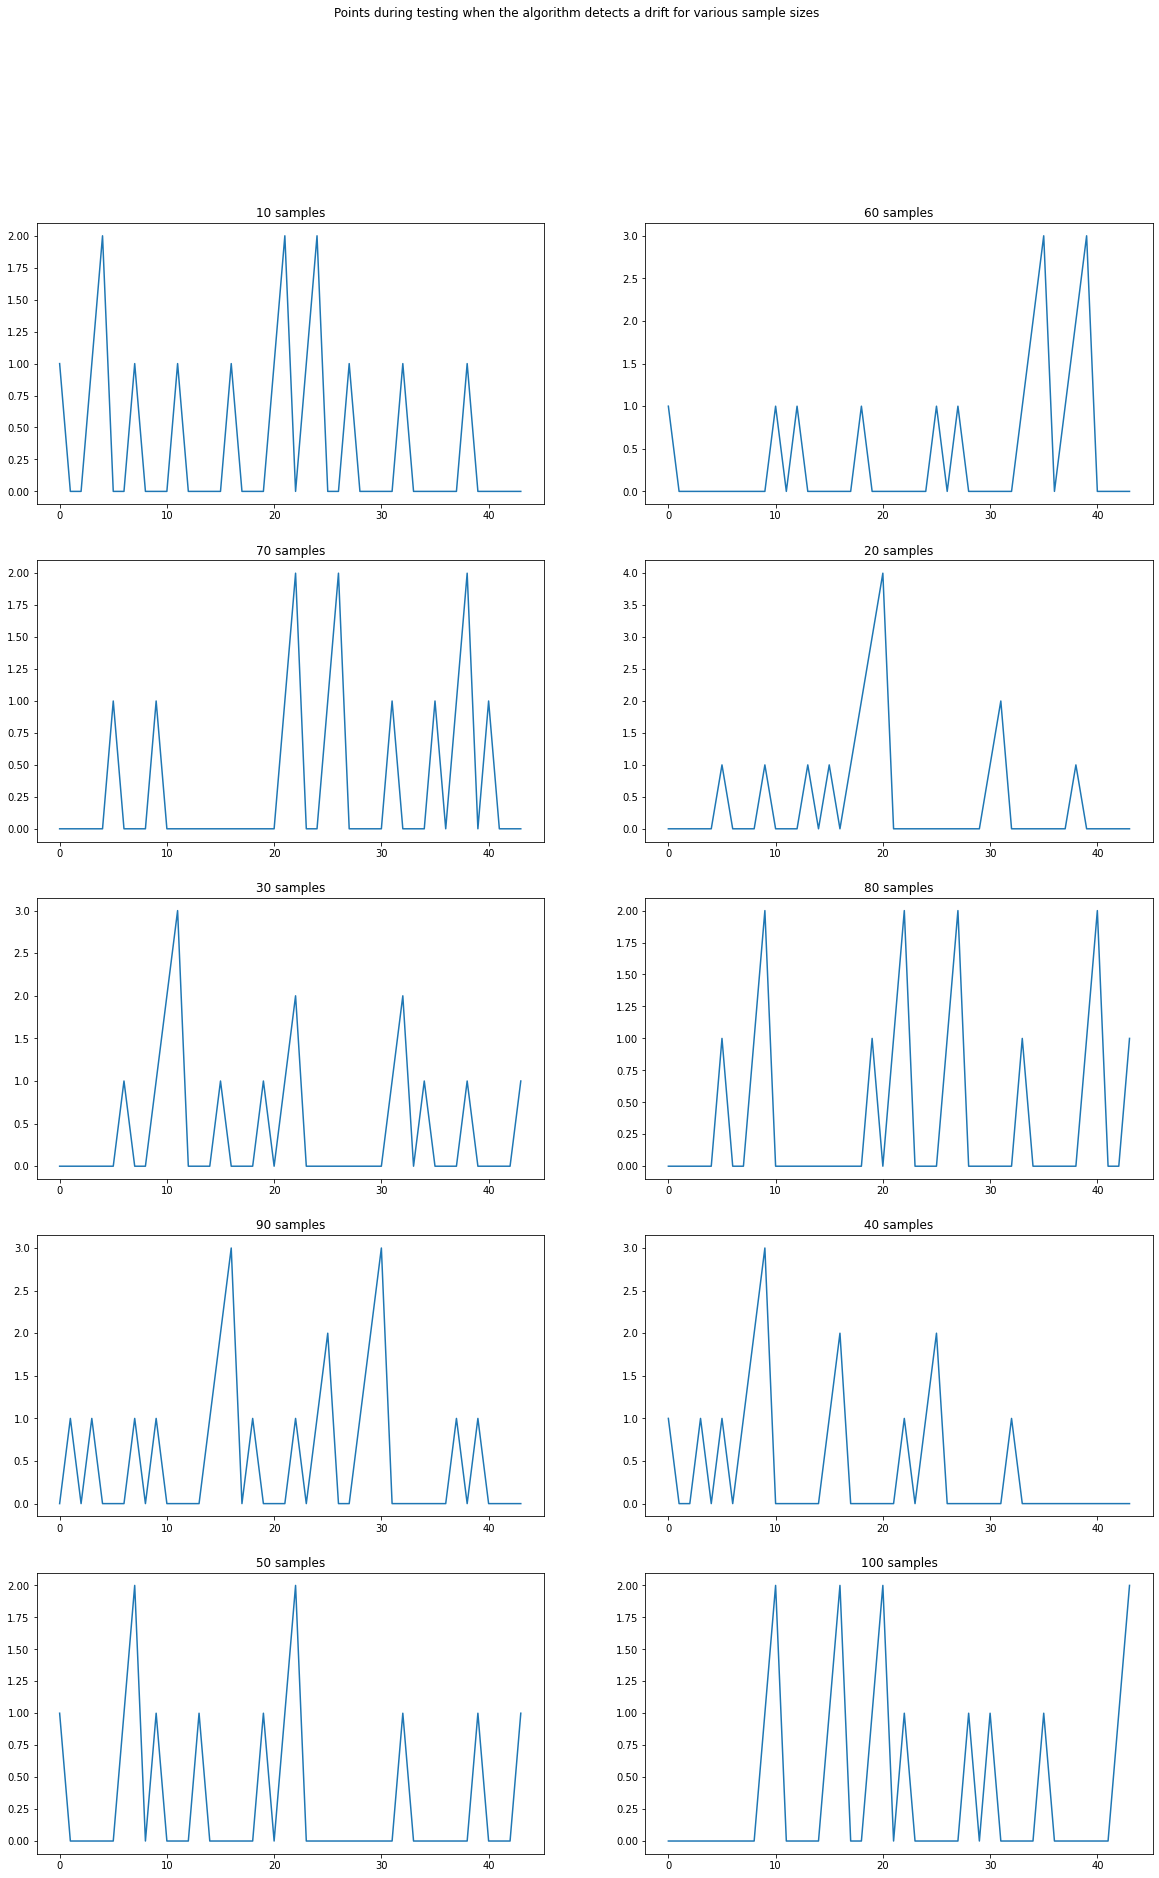

[26.406119385068333, 28.25948138567005, 28.964992991905195, 29.347624520390692, 30.017908479189547, 30.63707529661275, 31.40299044818304, 32.07580094549423, 33.19535317364256, 34.67911018438494]
[1.5292088282621867, 0.9882796025744851, 0.7435212084909308, 0.8466852297094367, 0.7827070091683217, 0.9488765791806005, 0.9104097487104835, 0.9740720573197552, 1.0420947218037293, 1.3358971906980197]
[0.28284502337715894, 0.2639069134642682, 0.2868699771972129, 0.33183698585427707, 0.36438127413088, 0.3983144369088287, 0.3484898264817528, 0.34481242424649156, 0.33158554826300696, 0.3052806855234962]
[0.16491438293984859, 0.09491252207679884, 0.0868762929298296, 0.09399701146236687, 0.07601065931023496, 0.08334863875376859, 0.08706267060809568, 0.08495057585668873, 0.0707756230204044, 0.06472124782081422]
(87, 100)
test data size = 87


10it [00:36,  3.64s/it]


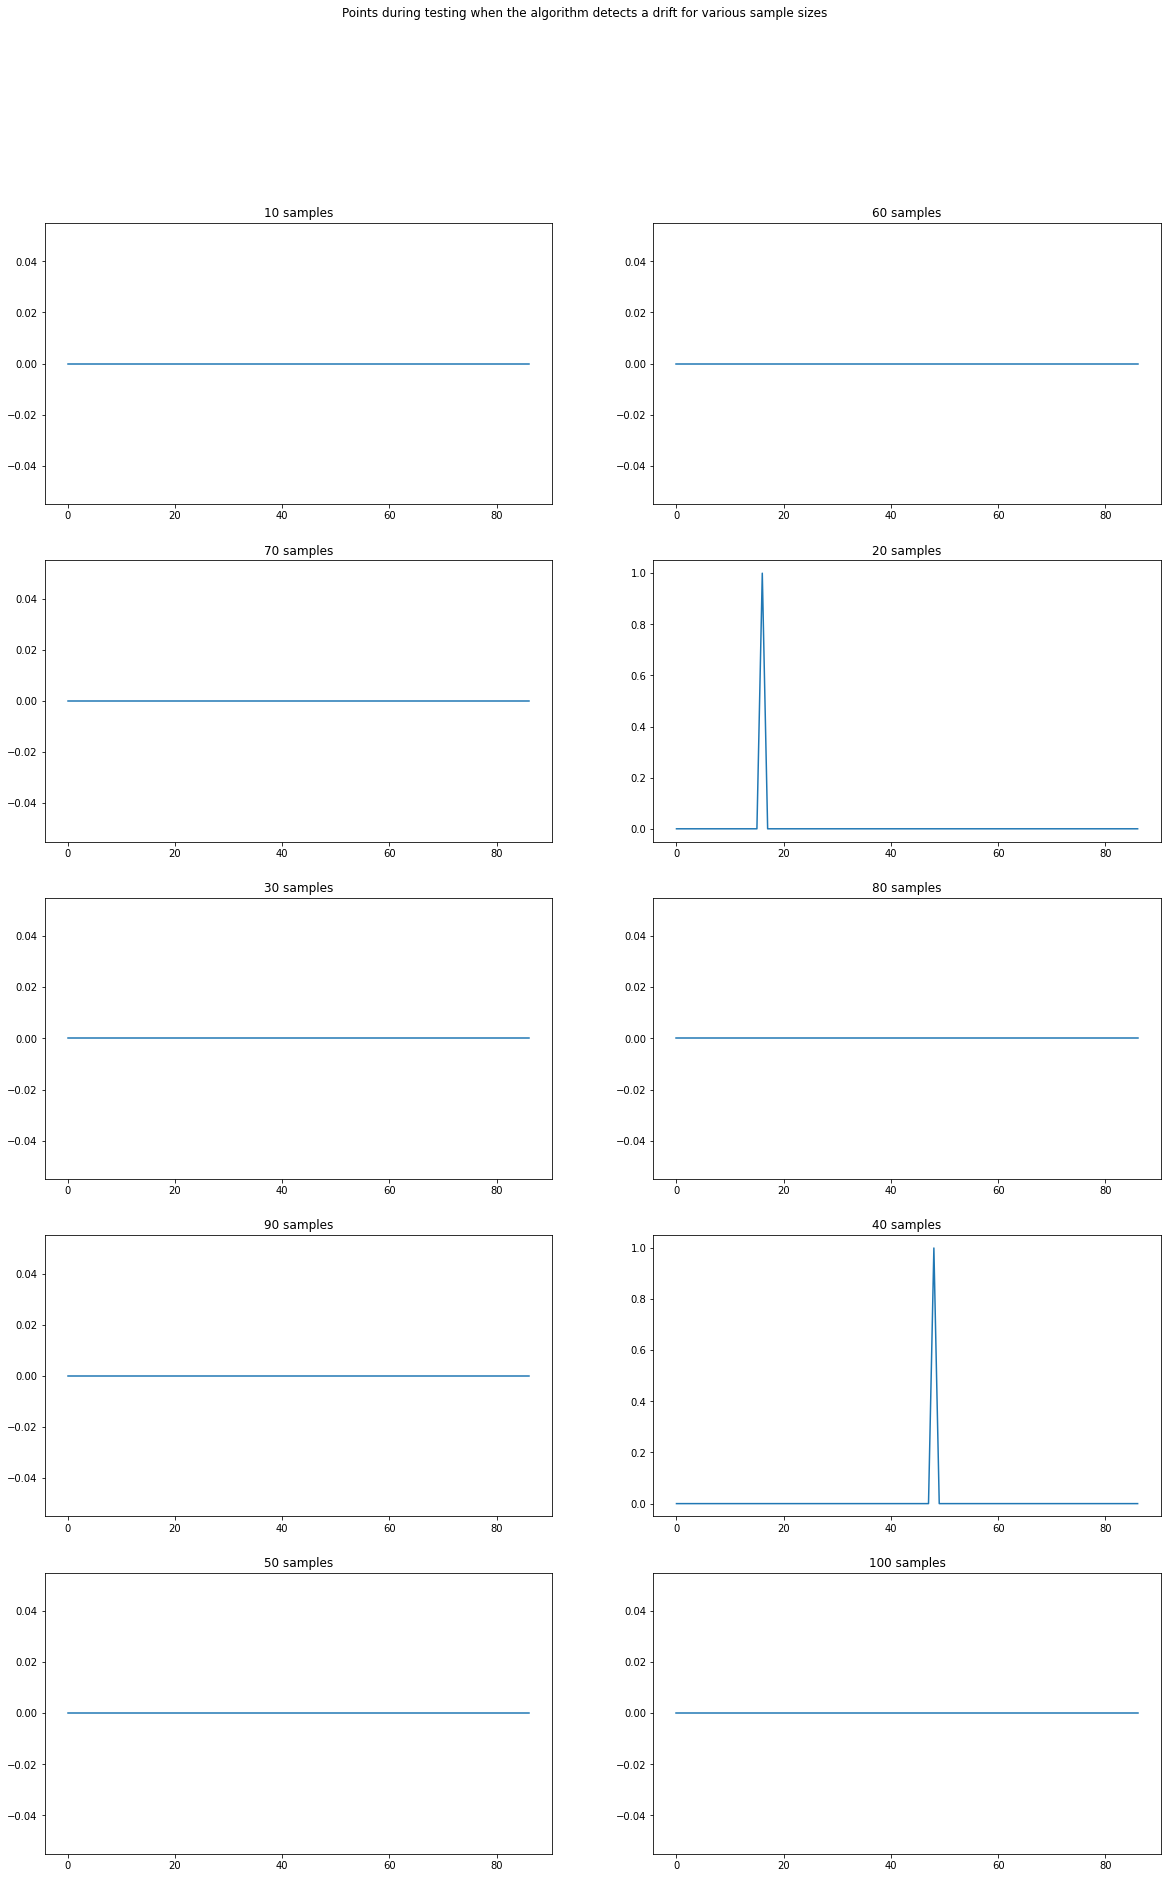

[27.882043630702068, 30.201195653080692, 30.95279156627839, 31.37098212436249, 31.839794715029065, 32.54876426170252, 33.18069279993759, 33.970451411674595, 35.20685316804988, 36.589585361302525]
[2.013626194791622, 1.0171952492357825, 0.9230948932266039, 0.9765322332954436, 0.9337635078336733, 1.0345987046239606, 1.0496480244509538, 1.171739215304263, 1.3161916788979944, 1.4729800035706018]
[0.3003129708613088, 0.2714751759319022, 0.28010968388390356, 0.3364738995016673, 0.35020501789292874, 0.35431255257559646, 0.361196741965323, 0.3527106449348201, 0.32136950000458187, 0.2999913350049852]
[0.18430459766746815, 0.10568175782176689, 0.09041407208813697, 0.09340033269341065, 0.08276783580339875, 0.07522881226773977, 0.08141775729060602, 0.07989826628155355, 0.0728917413596455, 0.06791425685487819]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Init

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


[27.77079967549321, 29.1344238240899, 30.200735849986874, 30.828994473577776, 31.25513023433641, 31.8174665451045, 32.3716550468788, 33.356253044907795, 34.357113182360486, 35.82206832185951]
[1.5671141182409063, 1.2489653085639045, 1.016411909054493, 0.7838245622352001, 0.8829777084954683, 0.9539546077305597, 1.0608599944919668, 1.1941255068586183, 1.3181566781696676, 1.3090775387057039]
[0.2146155102618539, 0.31880237055227856, 0.2997471876108104, 0.30393891646652965, 0.3415442966542377, 0.3283521604526209, 0.35259561122203853, 0.3473517127043795, 0.3278017688587844, 0.28410189114015616]
[0.10354216812530136, 0.1216671894446198, 0.08829178518007197, 0.07764619793363159, 0.0753584891299295, 0.07320062121995669, 0.07736237986037872, 0.09240617290056469, 0.07180454588549293, 0.05151460588403419]


10it [00:25,  2.55s/it]


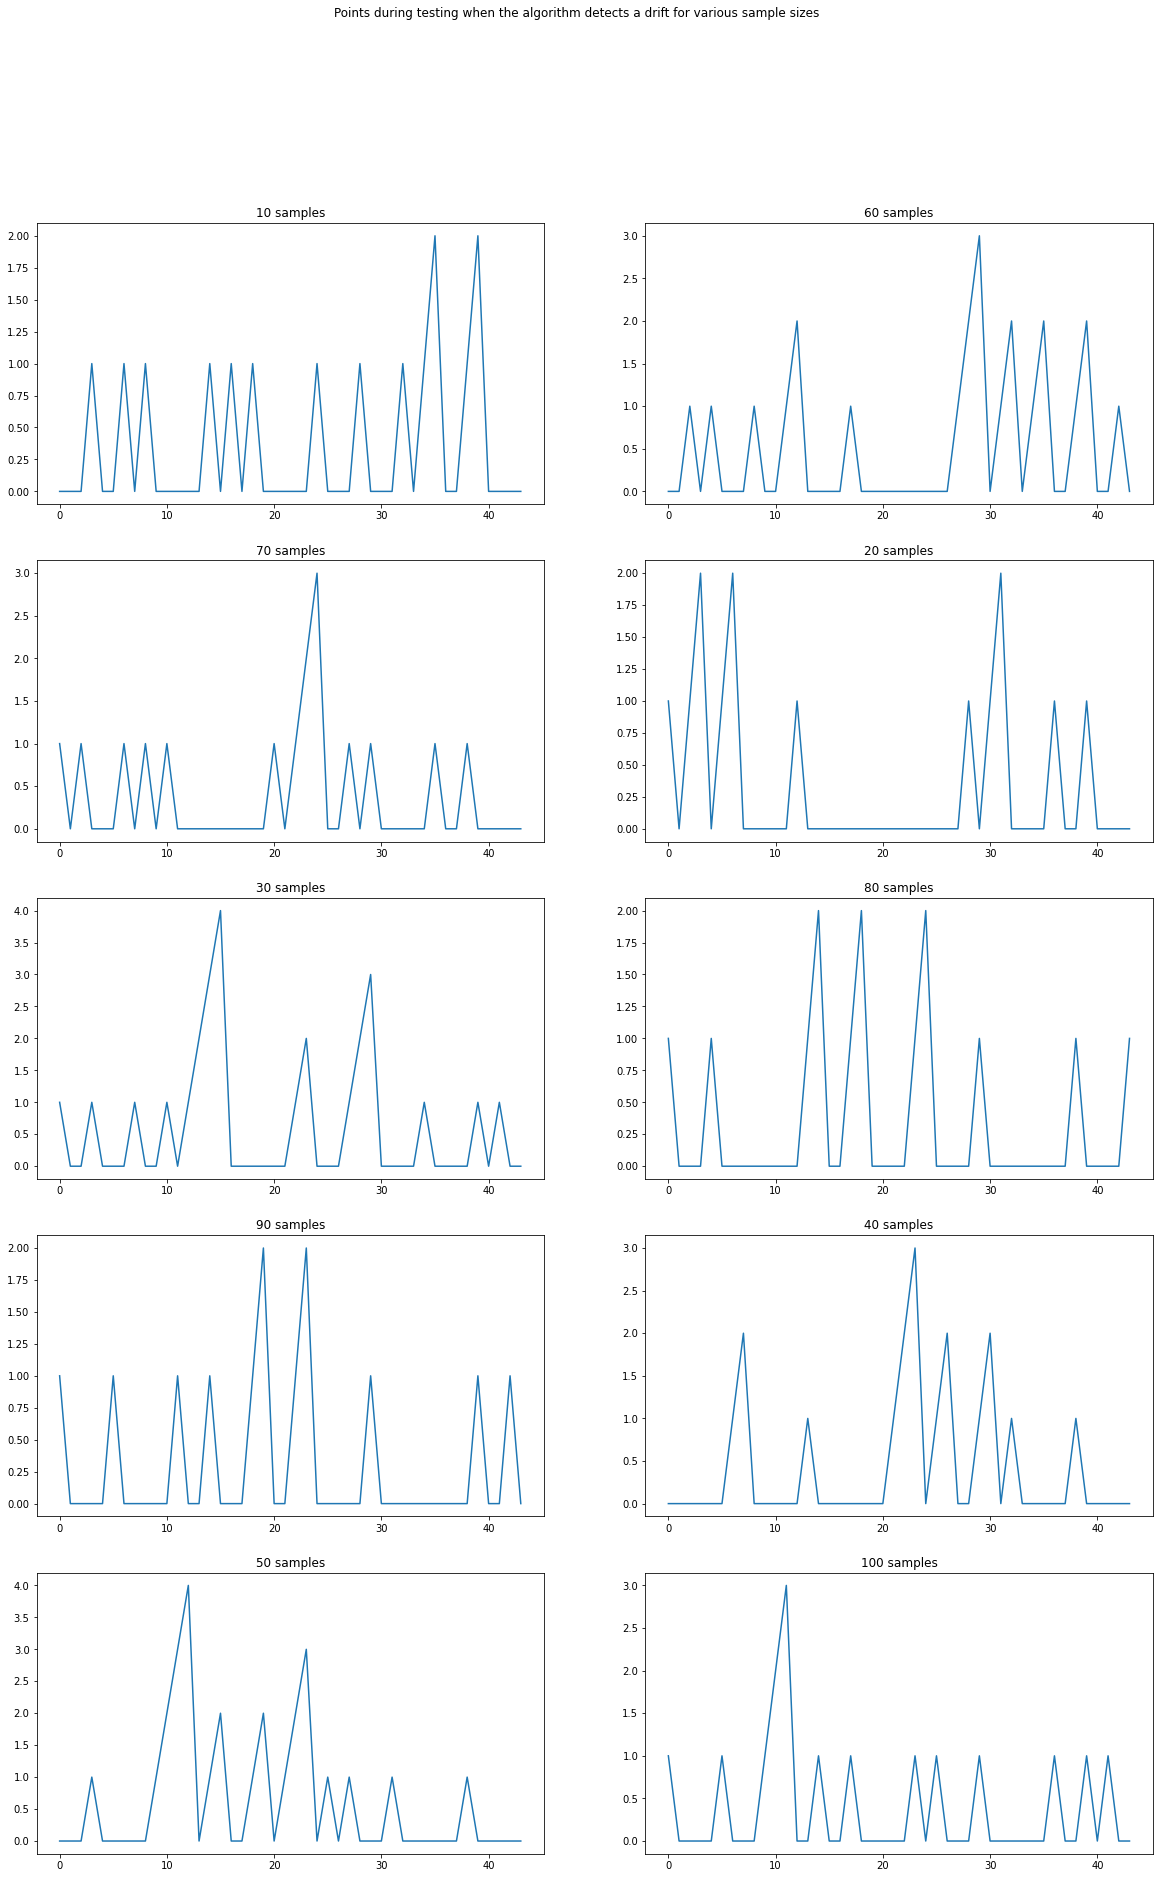

[27.77079967549321, 29.1344238240899, 30.200735849986874, 30.828994473577776, 31.25513023433641, 31.8174665451045, 32.3716550468788, 33.356253044907795, 34.357113182360486, 35.82206832185951]
[1.5671141182409063, 1.2489653085639045, 1.016411909054493, 0.7838245622352001, 0.8829777084954683, 0.9539546077305597, 1.0608599944919668, 1.1941255068586183, 1.3181566781696676, 1.3090775387057039]
[0.2146155102618539, 0.31880237055227856, 0.2997471876108104, 0.30393891646652965, 0.3415442966542377, 0.3283521604526209, 0.35259561122203853, 0.3473517127043795, 0.3278017688587844, 0.28410189114015616]
[0.10354216812530136, 0.1216671894446198, 0.08829178518007197, 0.07764619793363159, 0.0753584891299295, 0.07320062121995669, 0.07736237986037872, 0.09240617290056469, 0.07180454588549293, 0.05151460588403419]
(87, 100)
test data size = 87


10it [00:37,  3.73s/it]


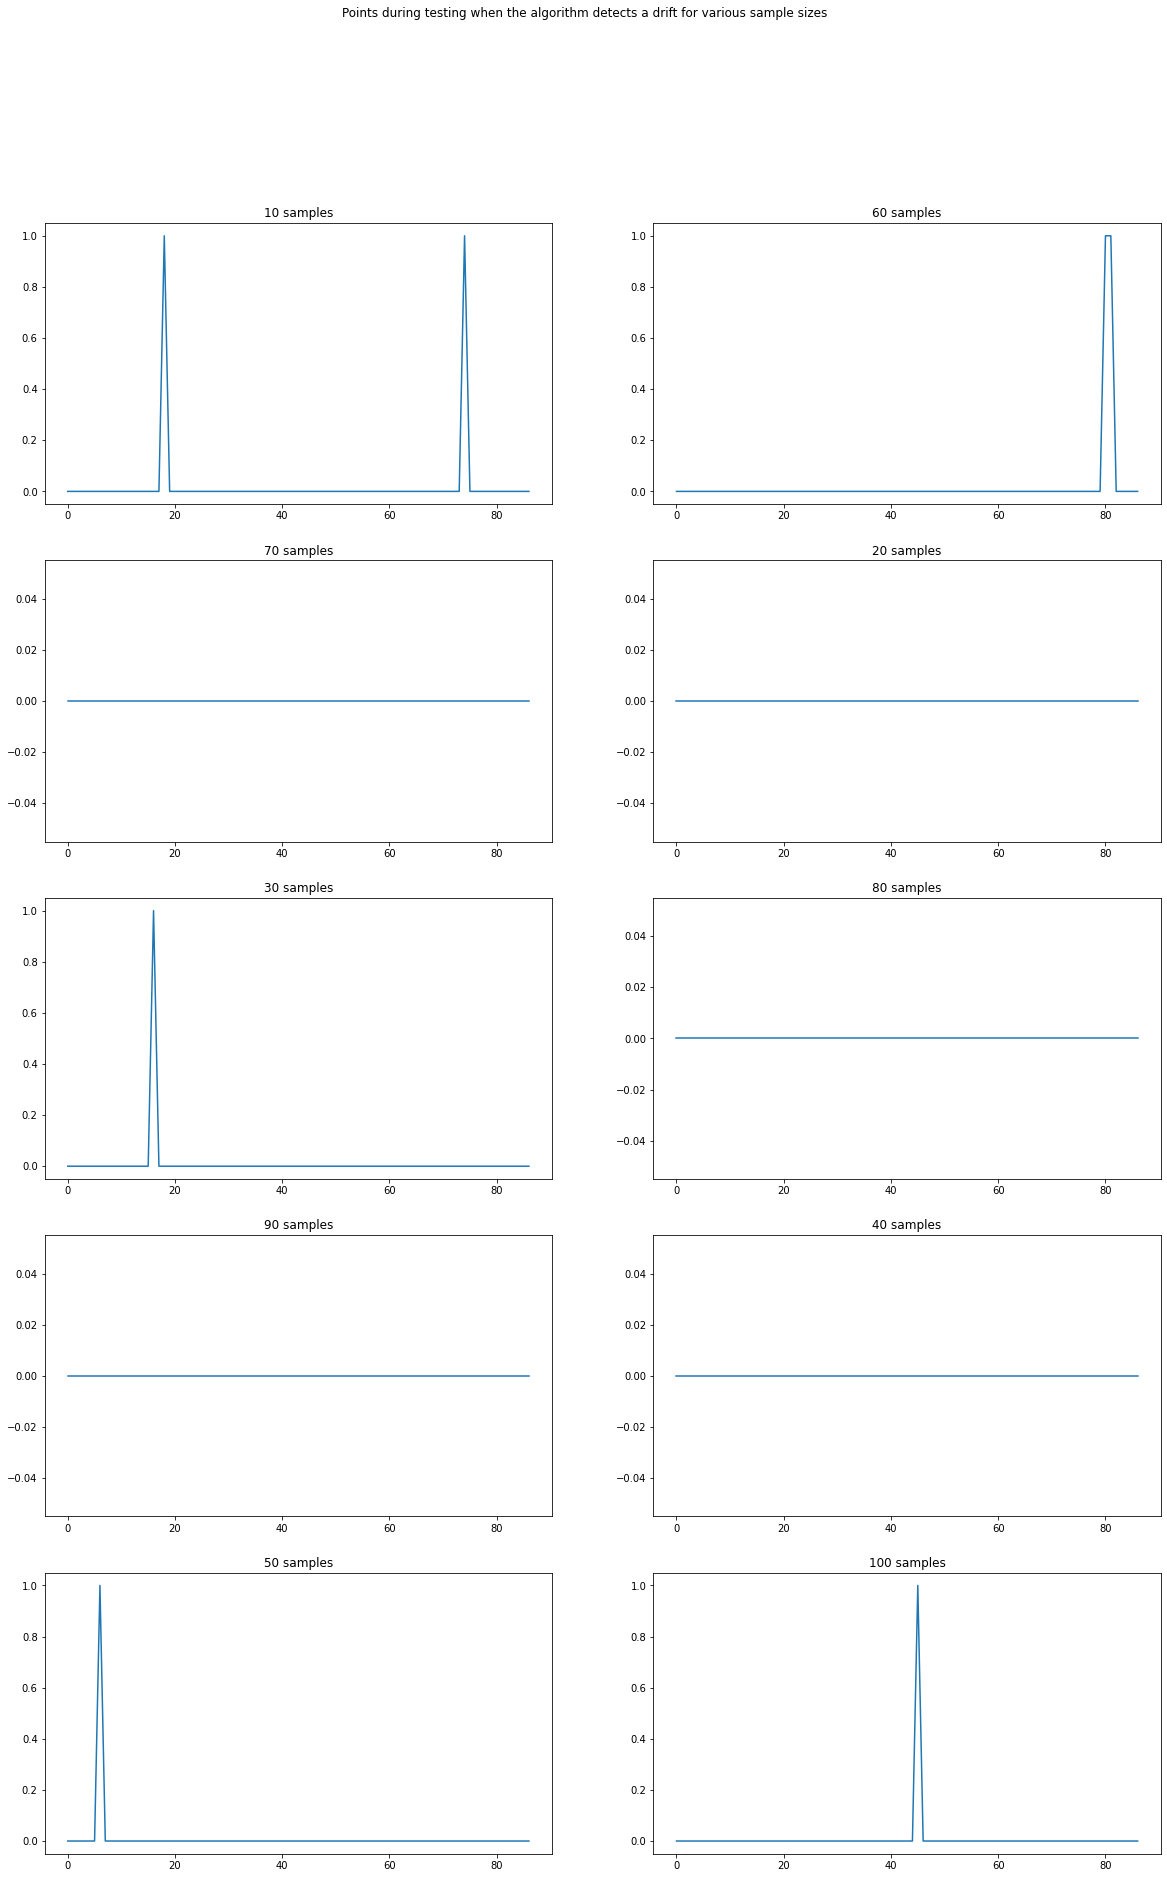

[26.20490629803667, 28.906612472711306, 30.152909121915176, 30.71548909764144, 31.254190031770456, 31.926190374143182, 32.43894228184972, 33.3535623229556, 34.644236015651416, 36.07976894470424]
[2.758718486854803, 1.2497697414563151, 0.9666581080721778, 0.9719181517703271, 0.9763252337779589, 1.0015549067411984, 1.1067876938134096, 1.3524646160691343, 1.4135745039084606, 1.463155096653421]
[0.3079901770553763, 0.3169210168869152, 0.3087346682879232, 0.32833693347127535, 0.35890403106165125, 0.34524215428051674, 0.3709760189630506, 0.36575104665903013, 0.33563182669551805, 0.2941582321265111]
[0.1912352958957316, 0.1279685853340505, 0.09507800220496489, 0.08261817340222724, 0.099709712976604, 0.0801566216354102, 0.08515916510620637, 0.08867386357125766, 0.07113452659486554, 0.07030756392634799]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initial

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


[26.126018755971153, 27.68757001666661, 28.37240176748364, 28.826422535230915, 29.42880430556586, 29.98583355921928, 30.76473836607781, 31.491050350609203, 32.72399598391218, 34.03818283572928]
[1.653995179682953, 0.894991446923666, 0.6936262487063667, 0.8024092047812773, 0.8236969119237785, 0.9570815119252877, 0.9795229939112028, 0.8591346992725978, 1.0862820739356926, 1.2184238470274906]
[0.289761625773964, 0.2797561437392733, 0.2959901309362212, 0.3423491391371343, 0.3277545841927311, 0.366912300934732, 0.33596907425580047, 0.3479002469612157, 0.3111164216359976, 0.28597226844076634]
[0.19704117525498355, 0.10147771963772445, 0.09519883712193102, 0.07904312881741377, 0.08895528778789173, 0.08237727129236047, 0.08889218285083411, 0.06580724635952376, 0.07374665222199282, 0.06347975940136127]


10it [00:47,  4.72s/it]


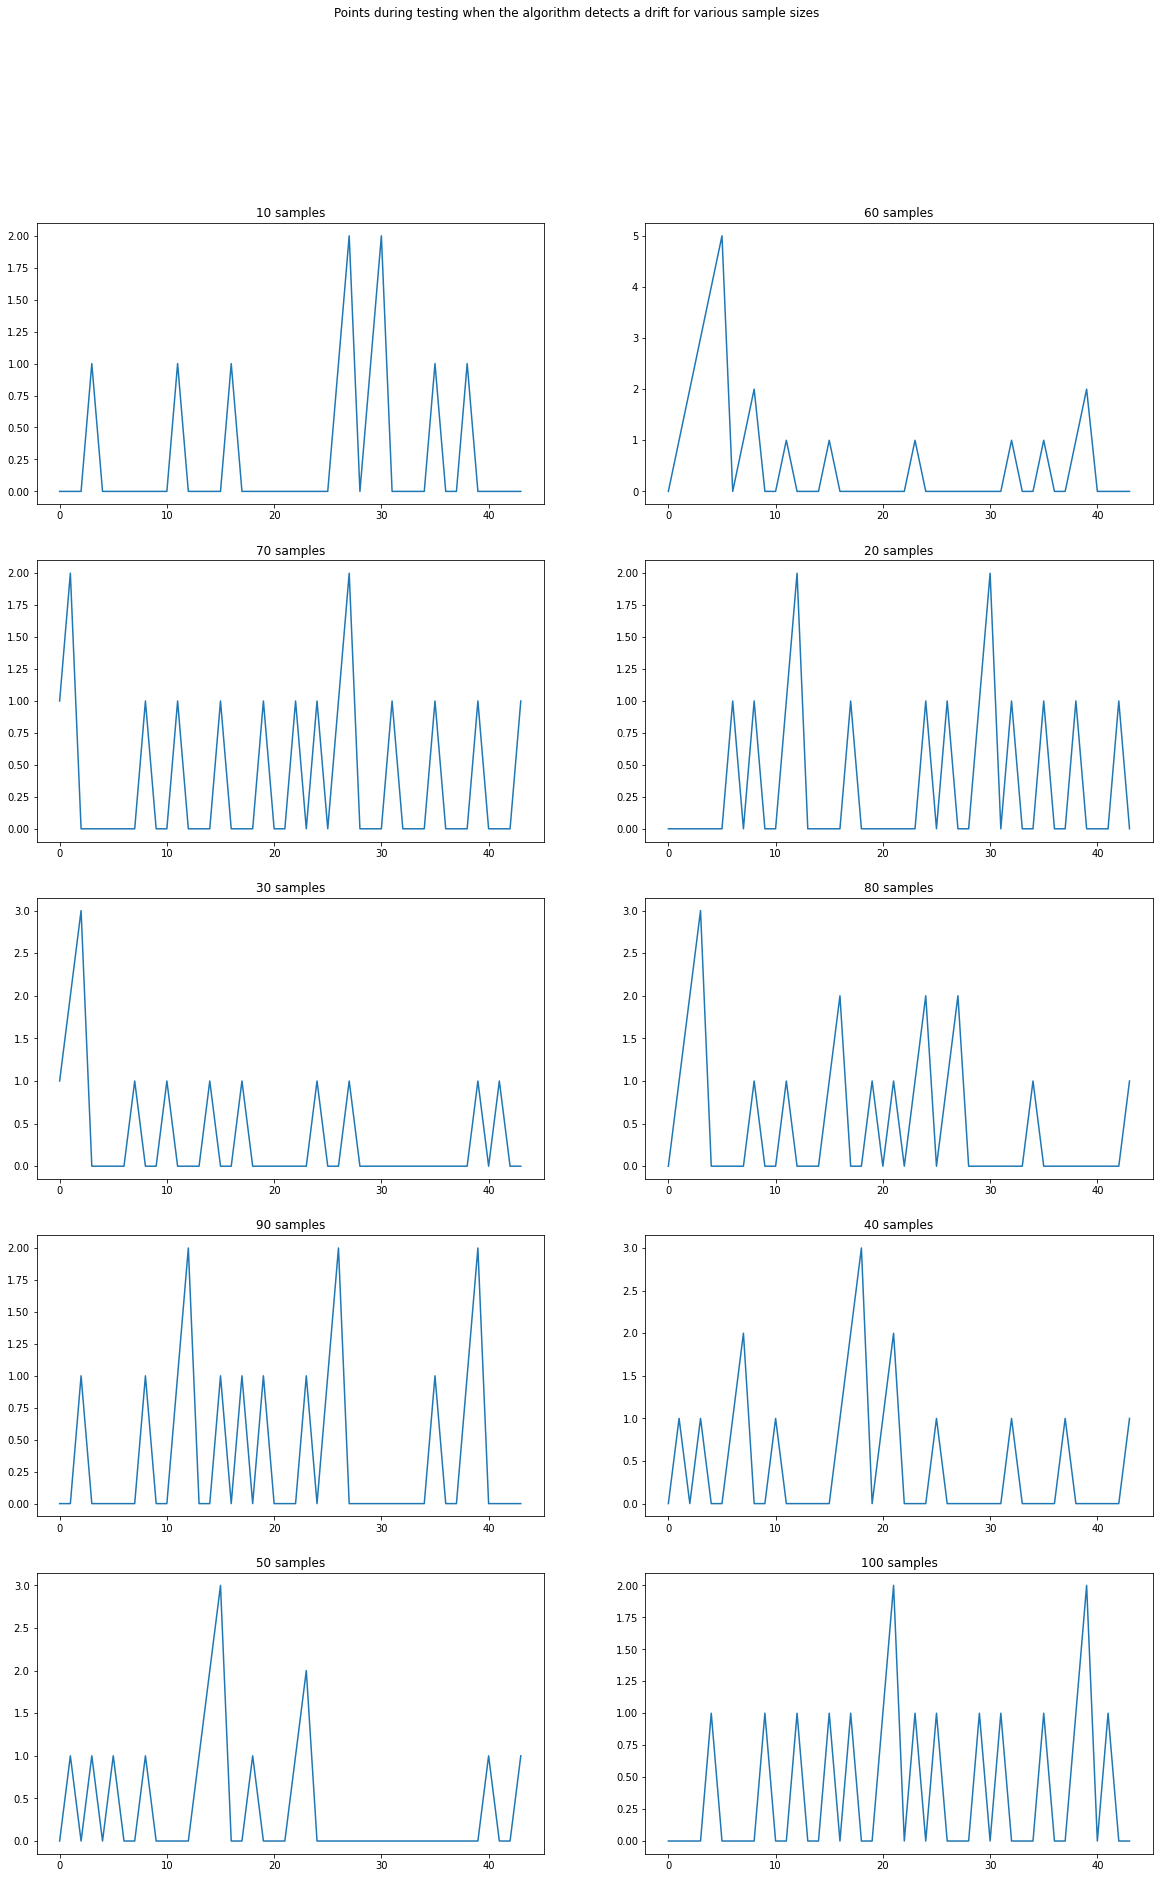

[26.126018755971153, 27.68757001666661, 28.37240176748364, 28.826422535230915, 29.42880430556586, 29.98583355921928, 30.76473836607781, 31.491050350609203, 32.72399598391218, 34.03818283572928]
[1.653995179682953, 0.894991446923666, 0.6936262487063667, 0.8024092047812773, 0.8236969119237785, 0.9570815119252877, 0.9795229939112028, 0.8591346992725978, 1.0862820739356926, 1.2184238470274906]
[0.289761625773964, 0.2797561437392733, 0.2959901309362212, 0.3423491391371343, 0.3277545841927311, 0.366912300934732, 0.33596907425580047, 0.3479002469612157, 0.3111164216359976, 0.28597226844076634]
[0.19704117525498355, 0.10147771963772445, 0.09519883712193102, 0.07904312881741377, 0.08895528778789173, 0.08237727129236047, 0.08889218285083411, 0.06580724635952376, 0.07374665222199282, 0.06347975940136127]
(87, 100)
test data size = 87


10it [01:11,  7.17s/it]


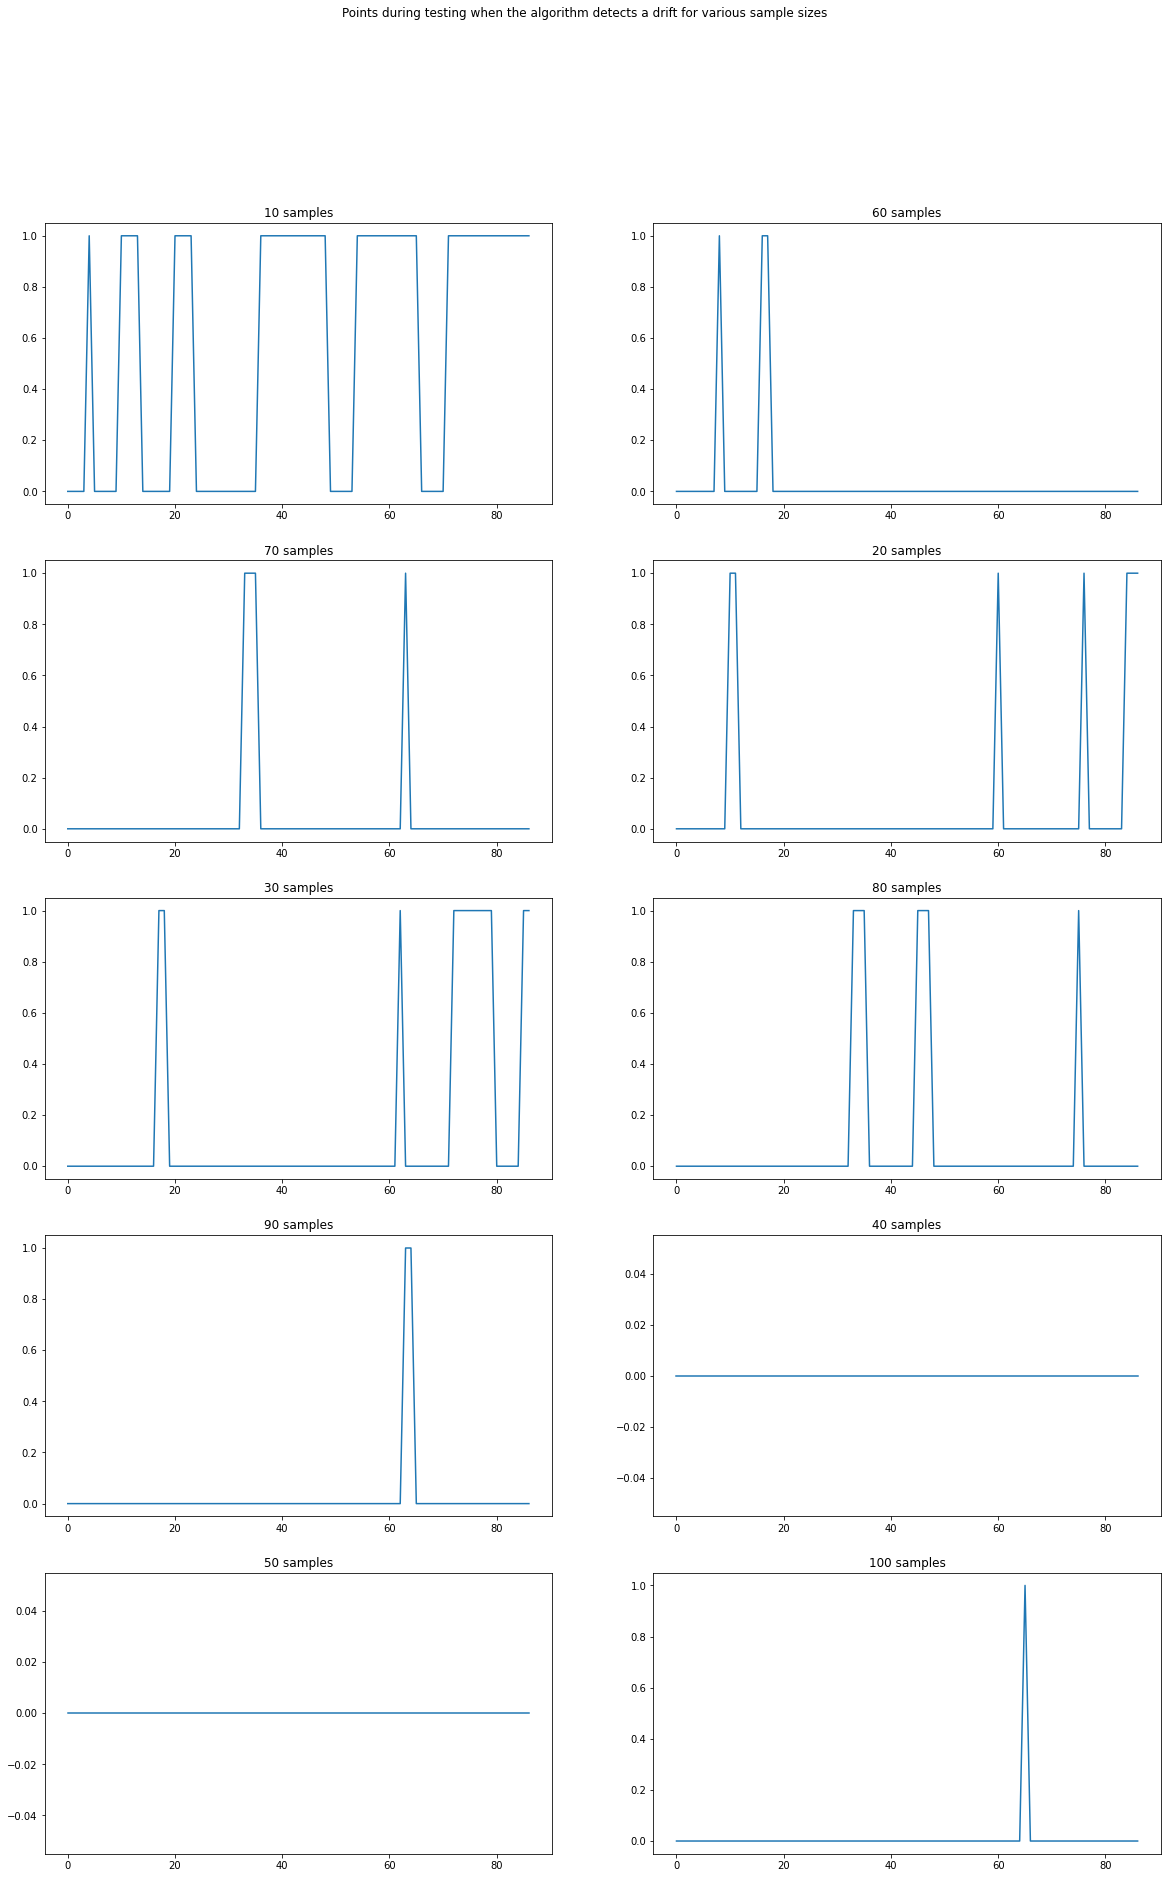

[23.05730091364212, 28.021817258616867, 29.010730420467905, 29.780337880031485, 30.21113351304548, 30.756386918571057, 31.497510544517844, 32.426948946362614, 33.65993907704509, 35.18854458882518]
[1.788404835181028, 1.1450294511002614, 1.0188766331688903, 0.8685660691689121, 0.8695877599004139, 0.9266175713804513, 0.9853783787529702, 1.1168636172065802, 1.3087339850056827, 1.416477792053071]
[0.9416114852104821, 0.3905935727969611, 0.3859295594488335, 0.35224662691700664, 0.37384887838782427, 0.4051312764292627, 0.40314851549858743, 0.4192627172539202, 0.3671752045543481, 0.3312496937995252]
[0.35521487867755464, 0.16990683416095584, 0.12209538441375065, 0.09460933270960746, 0.09860054123628303, 0.08491799879026865, 0.08467022059865116, 0.07917539297851679, 0.083201142917607, 0.07833420847111944]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Init

100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


[25.310337968443942, 27.738465359881573, 28.586411444909263, 29.291354741111874, 29.856386625096594, 30.429528813475034, 31.071334943895533, 31.733061162166255, 32.90782918130328, 34.15069994658373]
[2.426331498748815, 1.1543404242472128, 0.8728835647799135, 0.8741727317741161, 0.9148488660448596, 0.97063964165697, 1.0065911947286872, 1.0047209511458381, 1.2199312595590428, 1.0662203813357303]
[0.19360809104906115, 0.26480689572534827, 0.3118332473775719, 0.33762103884292133, 0.32878764594526017, 0.3654058776006503, 0.35958429641075884, 0.34740432246012487, 0.3201609159193341, 0.2920917540003036]
[0.09051132525776699, 0.10500443723214967, 0.09806728409874181, 0.09239048773794593, 0.061834426185652, 0.0789262914726014, 0.0803819202919237, 0.06648844797692814, 0.0741420680972433, 0.06352130749176968]


10it [00:46,  4.64s/it]


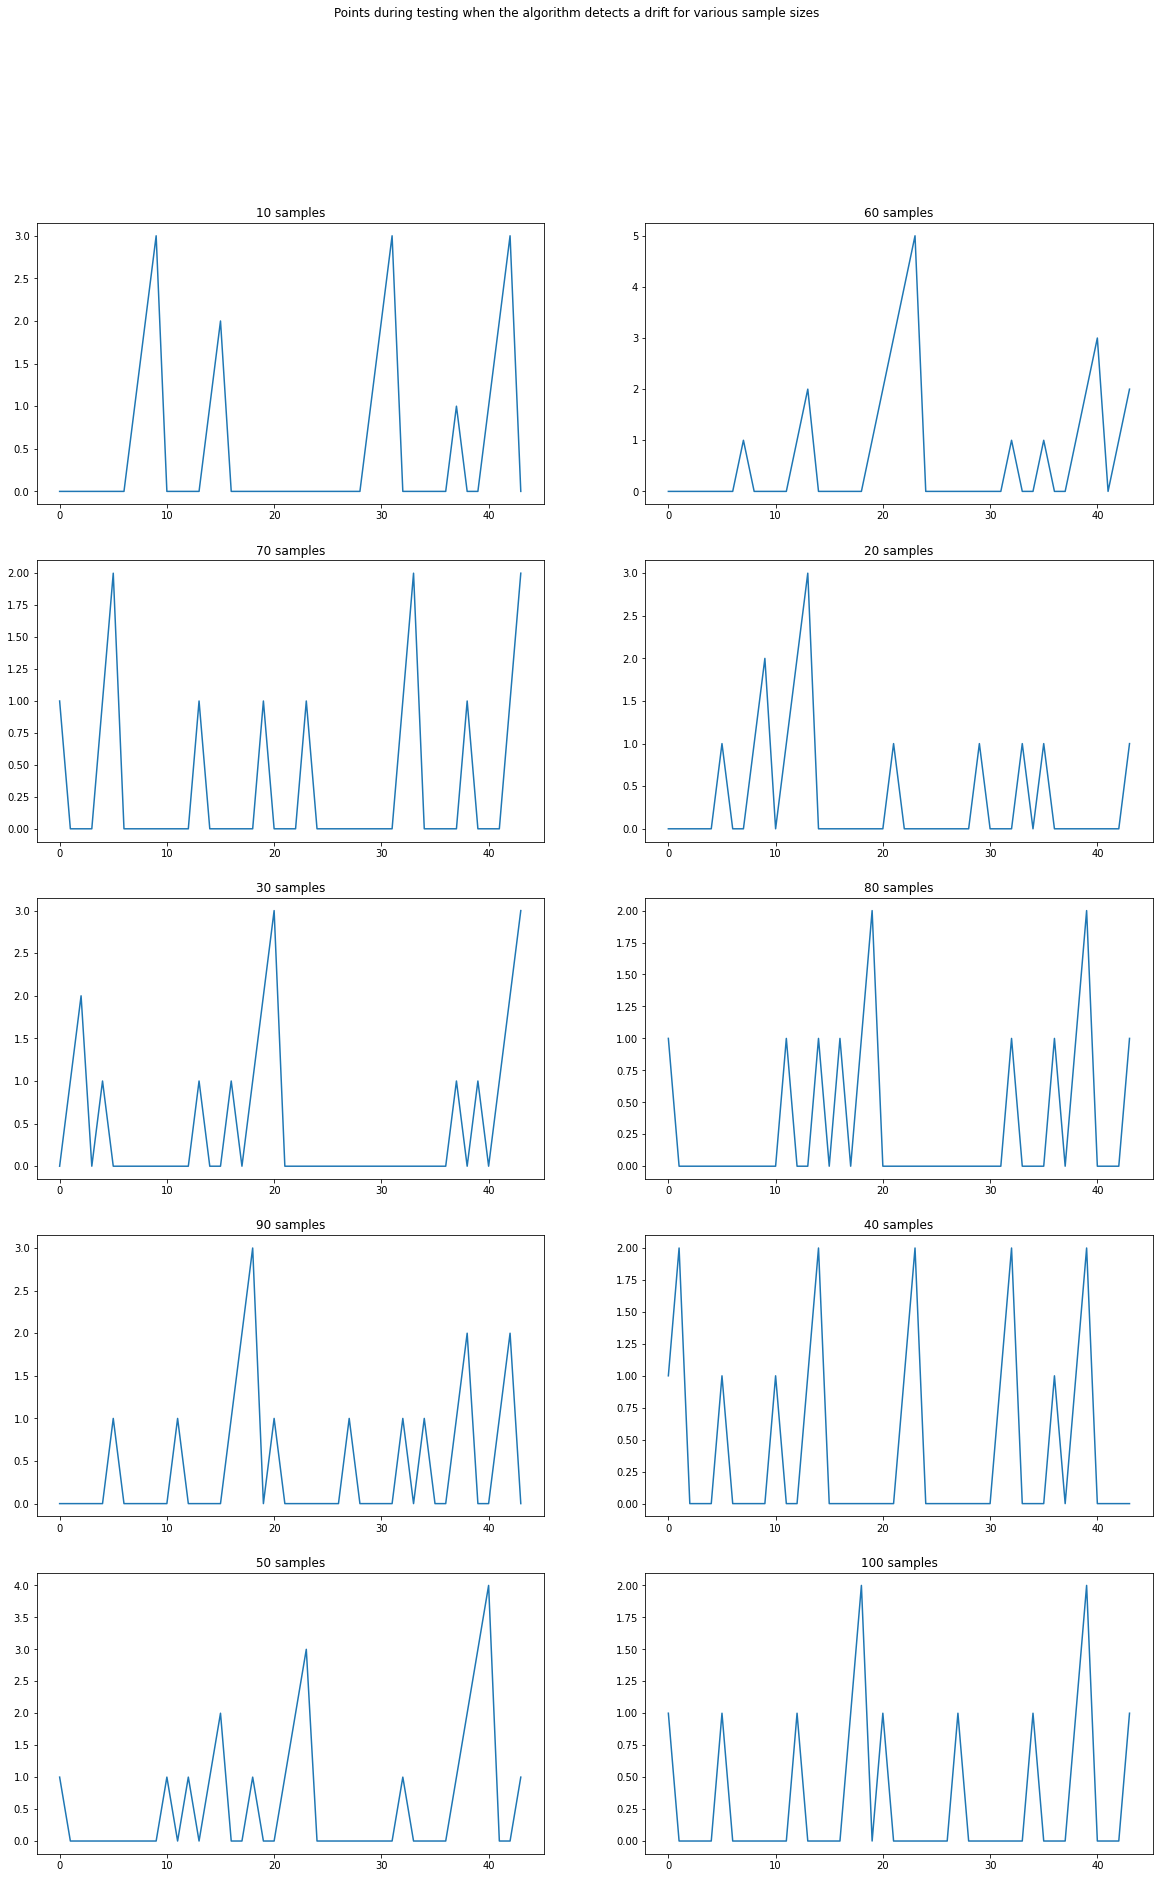

[25.310337968443942, 27.738465359881573, 28.586411444909263, 29.291354741111874, 29.856386625096594, 30.429528813475034, 31.071334943895533, 31.733061162166255, 32.90782918130328, 34.15069994658373]
[2.426331498748815, 1.1543404242472128, 0.8728835647799135, 0.8741727317741161, 0.9148488660448596, 0.97063964165697, 1.0065911947286872, 1.0047209511458381, 1.2199312595590428, 1.0662203813357303]
[0.19360809104906115, 0.26480689572534827, 0.3118332473775719, 0.33762103884292133, 0.32878764594526017, 0.3654058776006503, 0.35958429641075884, 0.34740432246012487, 0.3201609159193341, 0.2920917540003036]
[0.09051132525776699, 0.10500443723214967, 0.09806728409874181, 0.09239048773794593, 0.061834426185652, 0.0789262914726014, 0.0803819202919237, 0.06648844797692814, 0.0741420680972433, 0.06352130749176968]
(87, 100)
test data size = 87


10it [01:11,  7.11s/it]


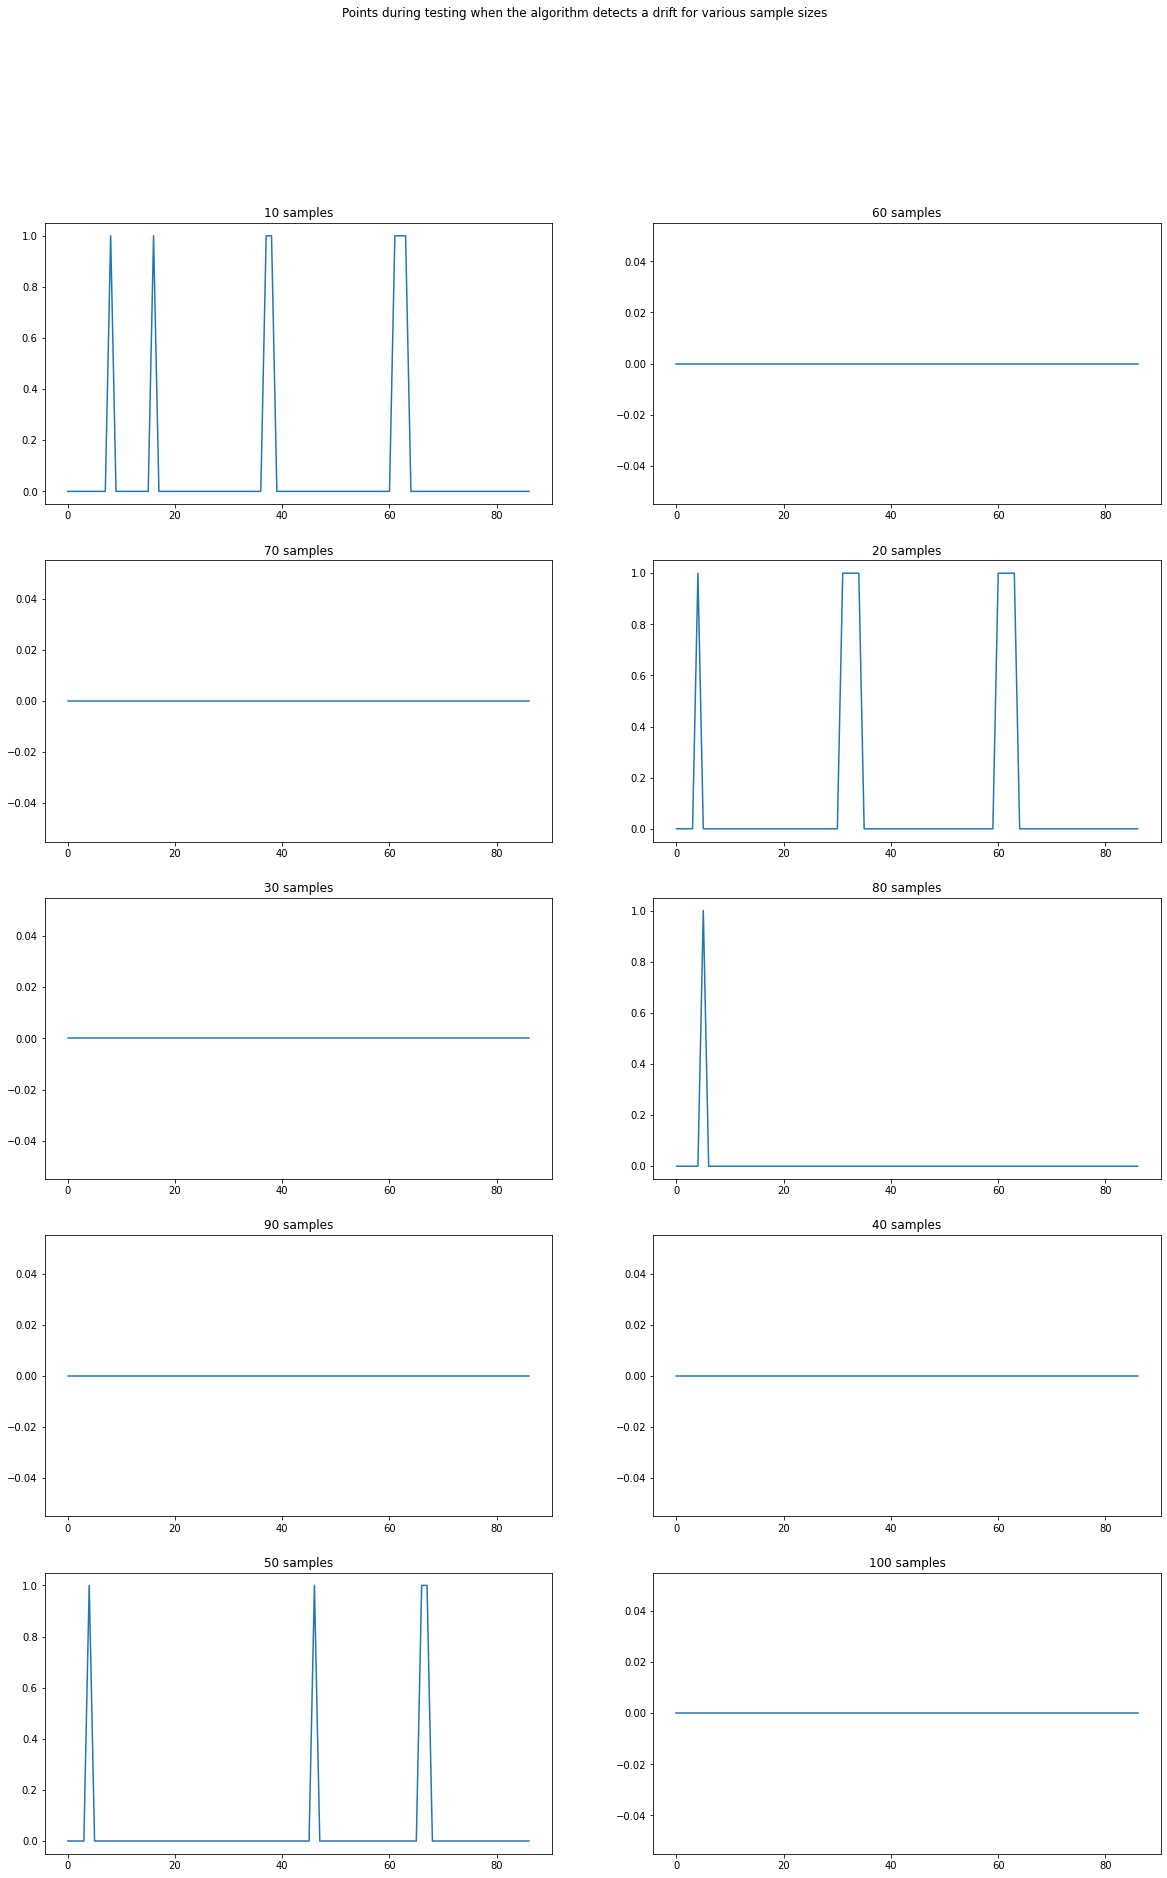

[18.439226176771907, 26.535861118653617, 28.419798732084818, 29.141121979088595, 29.609529379472484, 30.41828129604474, 31.254533550677355, 32.06822812837426, 32.98730928058088, 34.47124857664487]
[2.213799274718281, 1.2330611315966544, 0.9837193089174979, 0.936071385467182, 0.9412753272066704, 0.9303103008370147, 0.9424014377395257, 1.042066608621822, 1.2193220676554422, 1.341880264319147]
[0.3198173461457119, 0.3751711925262127, 0.31038809734184036, 0.35785283413827645, 0.3824370744567447, 0.41379633830099005, 0.3765606642975331, 0.36743723461688377, 0.3590831006492515, 0.31919848738128637]
[0.15144792683691155, 0.11765783014380089, 0.10735001913459936, 0.09782448442966582, 0.09185536050908345, 0.09649623765473382, 0.08181488747141212, 0.07460602698972273, 0.06774268597919532, 0.07371041124410382]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
In

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


[24.824112430673605, 26.682524978203492, 27.70369471858736, 28.12696806518898, 28.67263540545563, 29.306847522328553, 29.921027120533402, 30.854283437823653, 31.779118489924578, 33.011709834241664]
[1.9127890440625395, 0.8904162382599657, 0.7139891049624328, 0.7160924335941978, 0.7798449935654578, 0.7320048846388243, 0.8892535339632499, 1.0363441420272999, 1.2157563811286178, 1.3442312369527885]
[0.2846315007987415, 0.28241664937763633, 0.28952513668386504, 0.3359708723565847, 0.335676710258388, 0.354125322991116, 0.3432101313466246, 0.3380302429395646, 0.32353487588514757, 0.30019627672156474]
[0.15875047935472308, 0.11204622472793667, 0.07834083207759006, 0.07994139104174303, 0.0747791706104888, 0.07770659682537899, 0.07871110284370074, 0.07646517322260536, 0.0709947182426218, 0.05752094050502396]


10it [00:26,  2.68s/it]


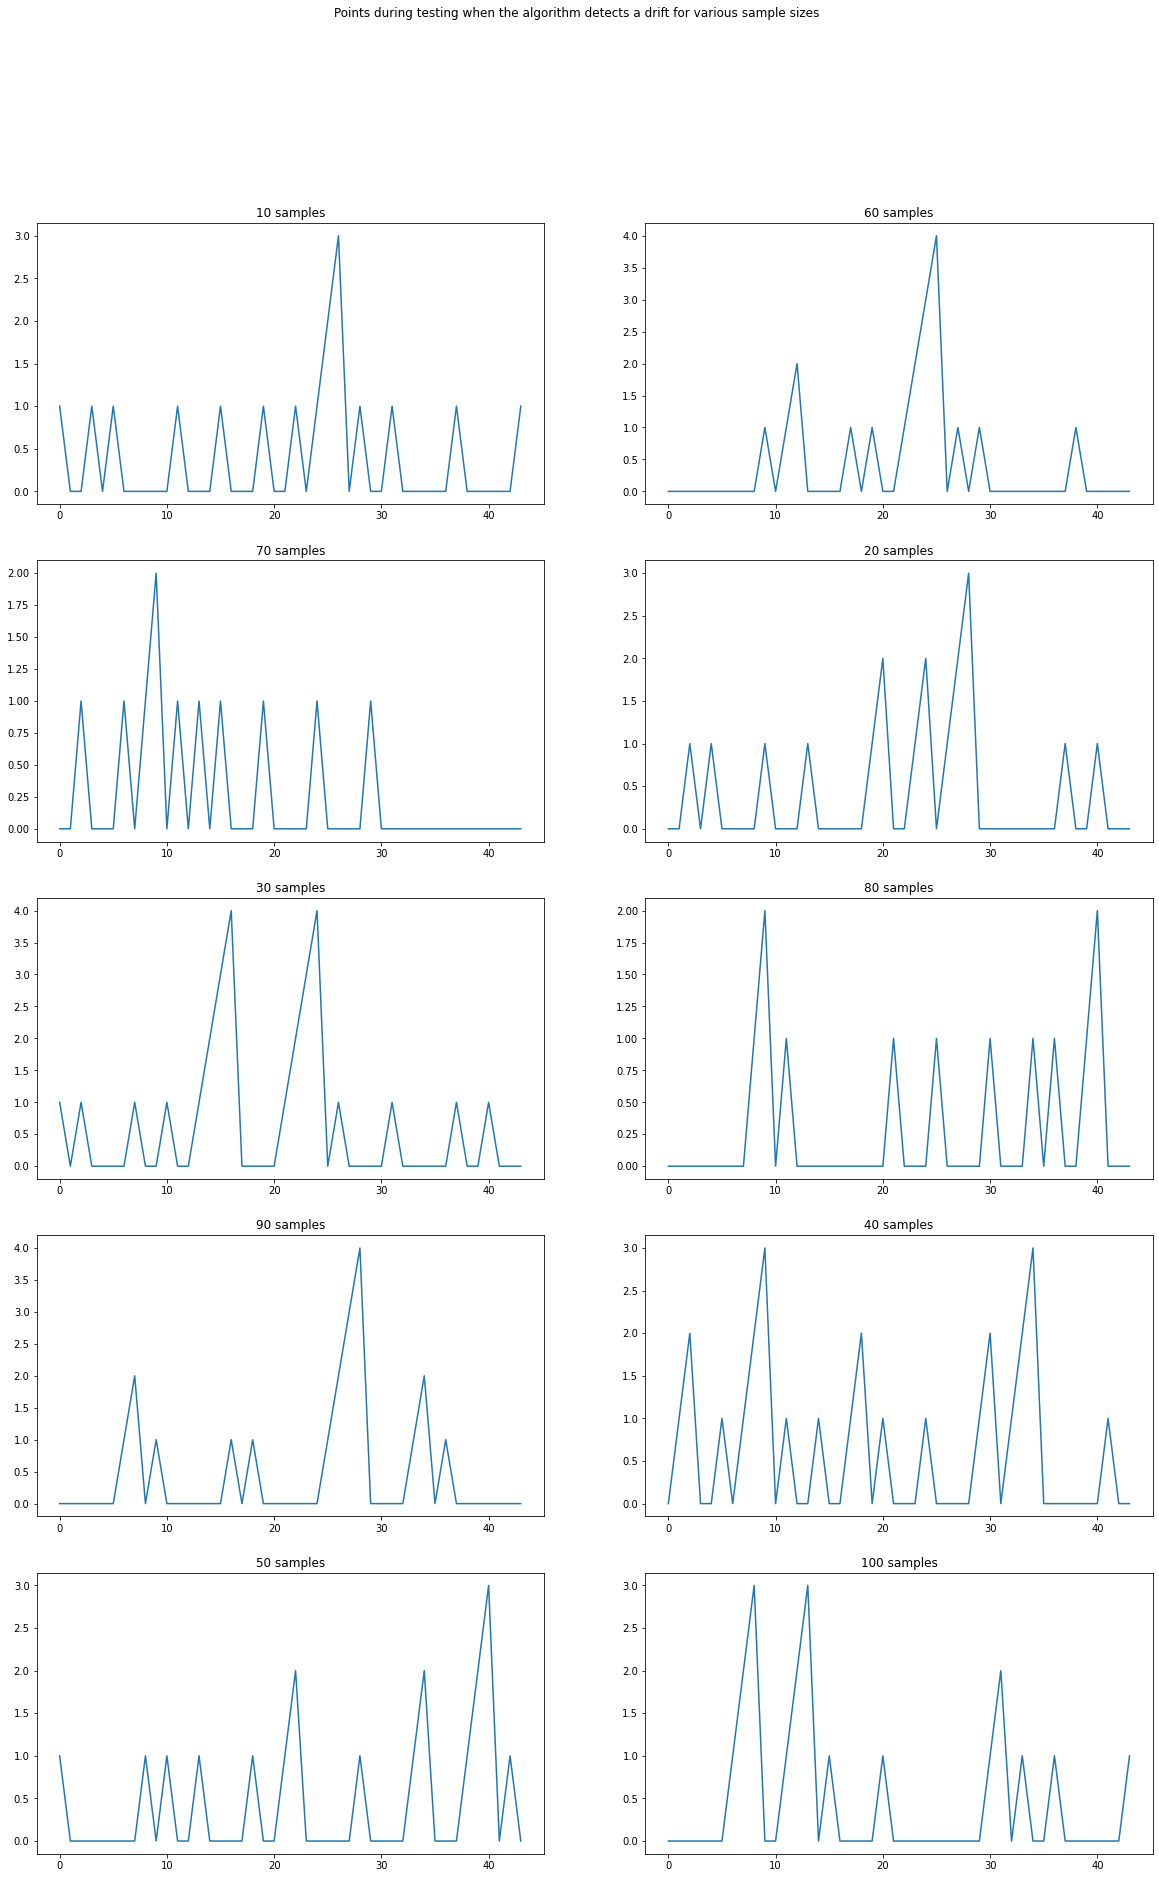

[24.824112430673605, 26.682524978203492, 27.70369471858736, 28.12696806518898, 28.67263540545563, 29.306847522328553, 29.921027120533402, 30.854283437823653, 31.779118489924578, 33.011709834241664]
[1.9127890440625395, 0.8904162382599657, 0.7139891049624328, 0.7160924335941978, 0.7798449935654578, 0.7320048846388243, 0.8892535339632499, 1.0363441420272999, 1.2157563811286178, 1.3442312369527885]
[0.2846315007987415, 0.28241664937763633, 0.28952513668386504, 0.3359708723565847, 0.335676710258388, 0.354125322991116, 0.3432101313466246, 0.3380302429395646, 0.32353487588514757, 0.30019627672156474]
[0.15875047935472308, 0.11204622472793667, 0.07834083207759006, 0.07994139104174303, 0.0747791706104888, 0.07770659682537899, 0.07871110284370074, 0.07646517322260536, 0.0709947182426218, 0.05752094050502396]
(87, 100)
test data size = 87


10it [00:36,  3.64s/it]


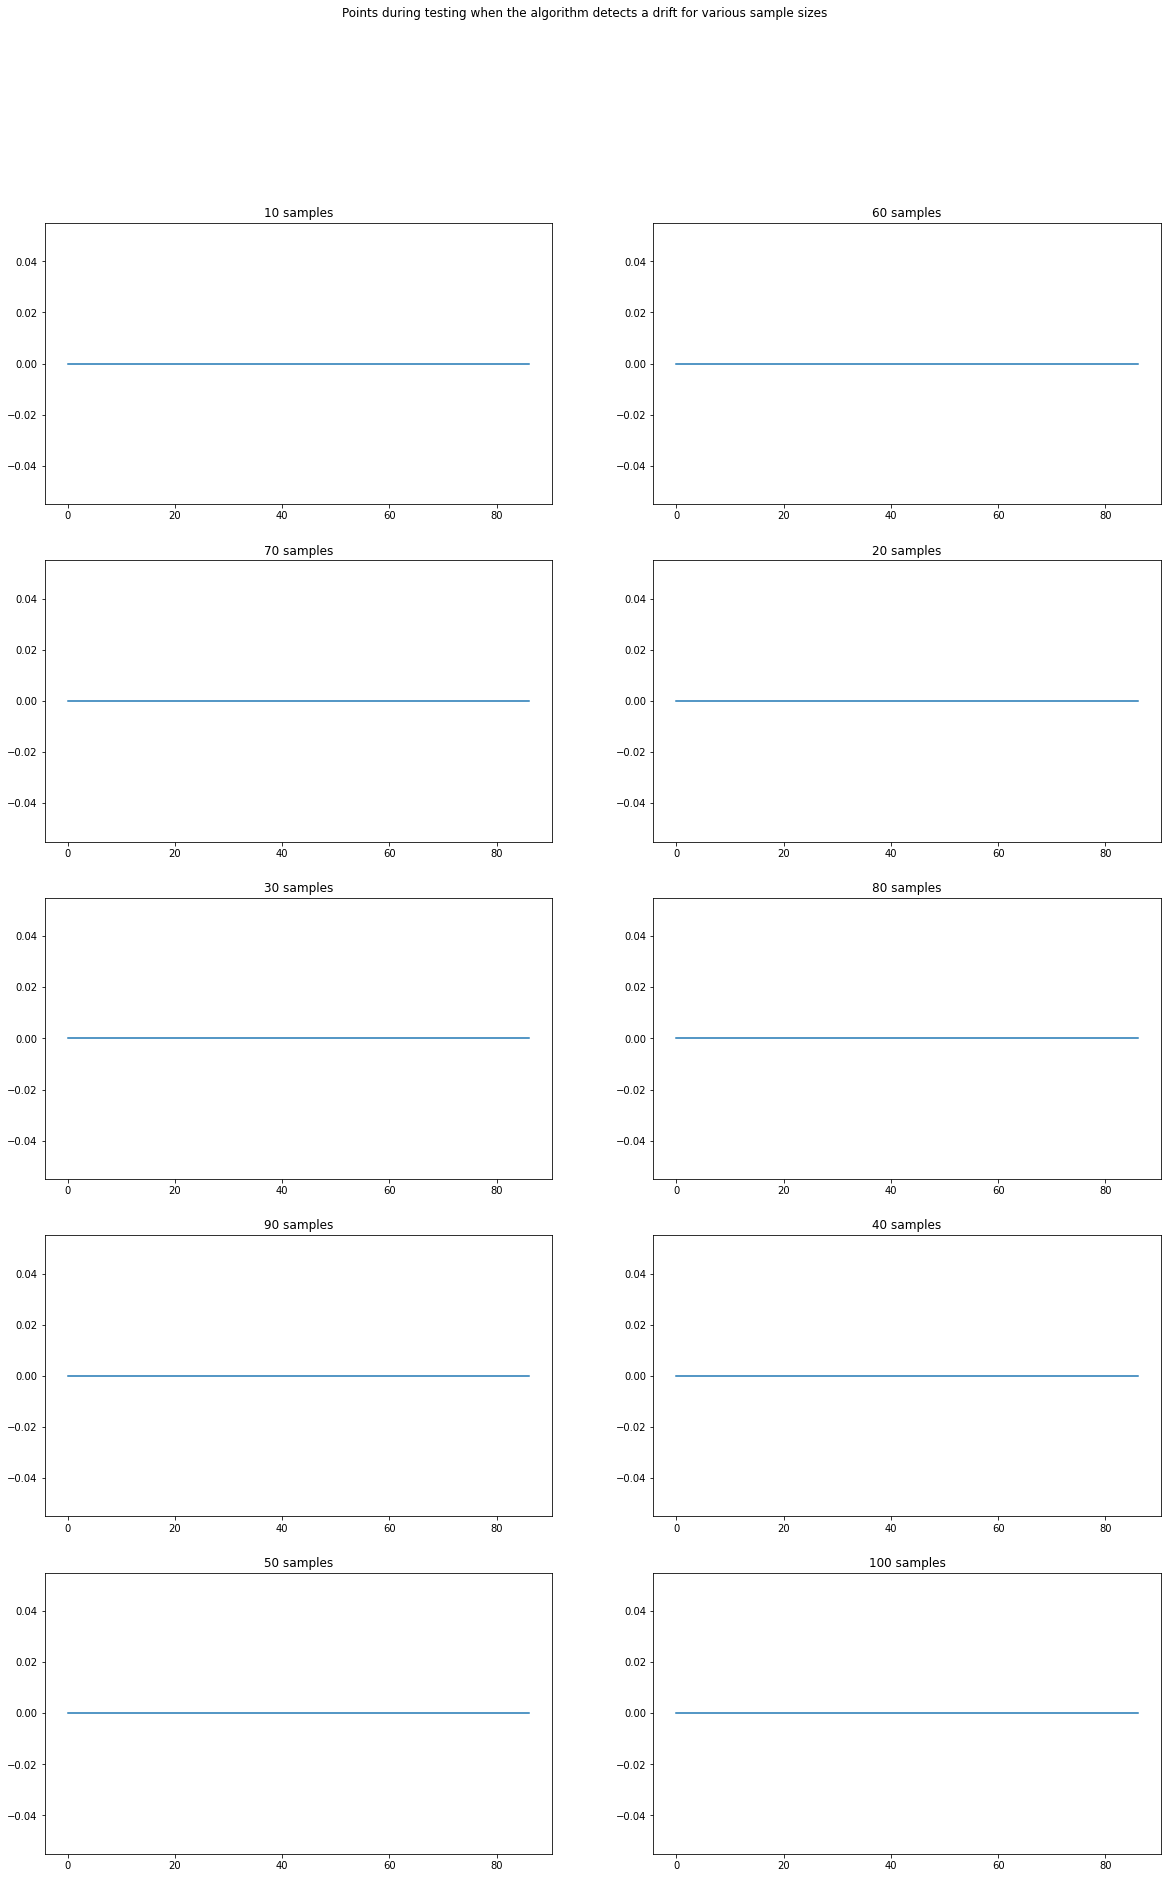

[25.178942416969544, 28.722167748762246, 29.537220178679565, 30.116030092599495, 30.693239230976435, 31.321725985385733, 31.96341129961252, 32.727062891702765, 33.5993456544182, 35.063073443445006]
[2.8499067872964523, 0.9506002834594044, 0.8031863297704523, 0.7764577082556281, 0.831955072336781, 0.8516917036421403, 0.926564441008082, 1.003322708413811, 1.126284225630983, 1.3929977521349495]
[0.30626877352184123, 0.2867374576585521, 0.3099474625733613, 0.3227587042222051, 0.3353761124291204, 0.3427684262659122, 0.3416350104983577, 0.34886630999322515, 0.33588137746632407, 0.3037060717529423]
[0.17912594614832628, 0.09490318170575021, 0.08179000837948043, 0.08162082722099316, 0.07483203688558251, 0.07122951551482765, 0.07527419645613735, 0.07031538371231891, 0.06444849043203796, 0.06884919607406365]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Ini

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


[26.468560867134247, 28.06315985973156, 28.713313059497754, 29.27617364854299, 29.89451356161825, 30.381659026274466, 30.951468262428417, 31.74615931629489, 32.4867626728778, 33.88613661369308]
[1.6618045258355614, 1.1050619002532127, 0.7686211923574047, 0.8588515283834959, 0.827370375994782, 0.8931749963729557, 0.9977407626883195, 0.9453481348381828, 1.0167225370242994, 1.3424973442474584]
[0.31820047437454974, 0.2734275433842532, 0.310278320529384, 0.322633580824674, 0.3412496565013503, 0.3399819481689709, 0.35071116290060017, 0.3365691355729783, 0.3288614994073108, 0.3023853213662775]
[0.1865290390091392, 0.10949533979117325, 0.09189932789883982, 0.09453620095472835, 0.09178700882746615, 0.06506219795607703, 0.0703096959305834, 0.07106734634464831, 0.07131739612514126, 0.06435780829796942]


10it [00:26,  2.61s/it]


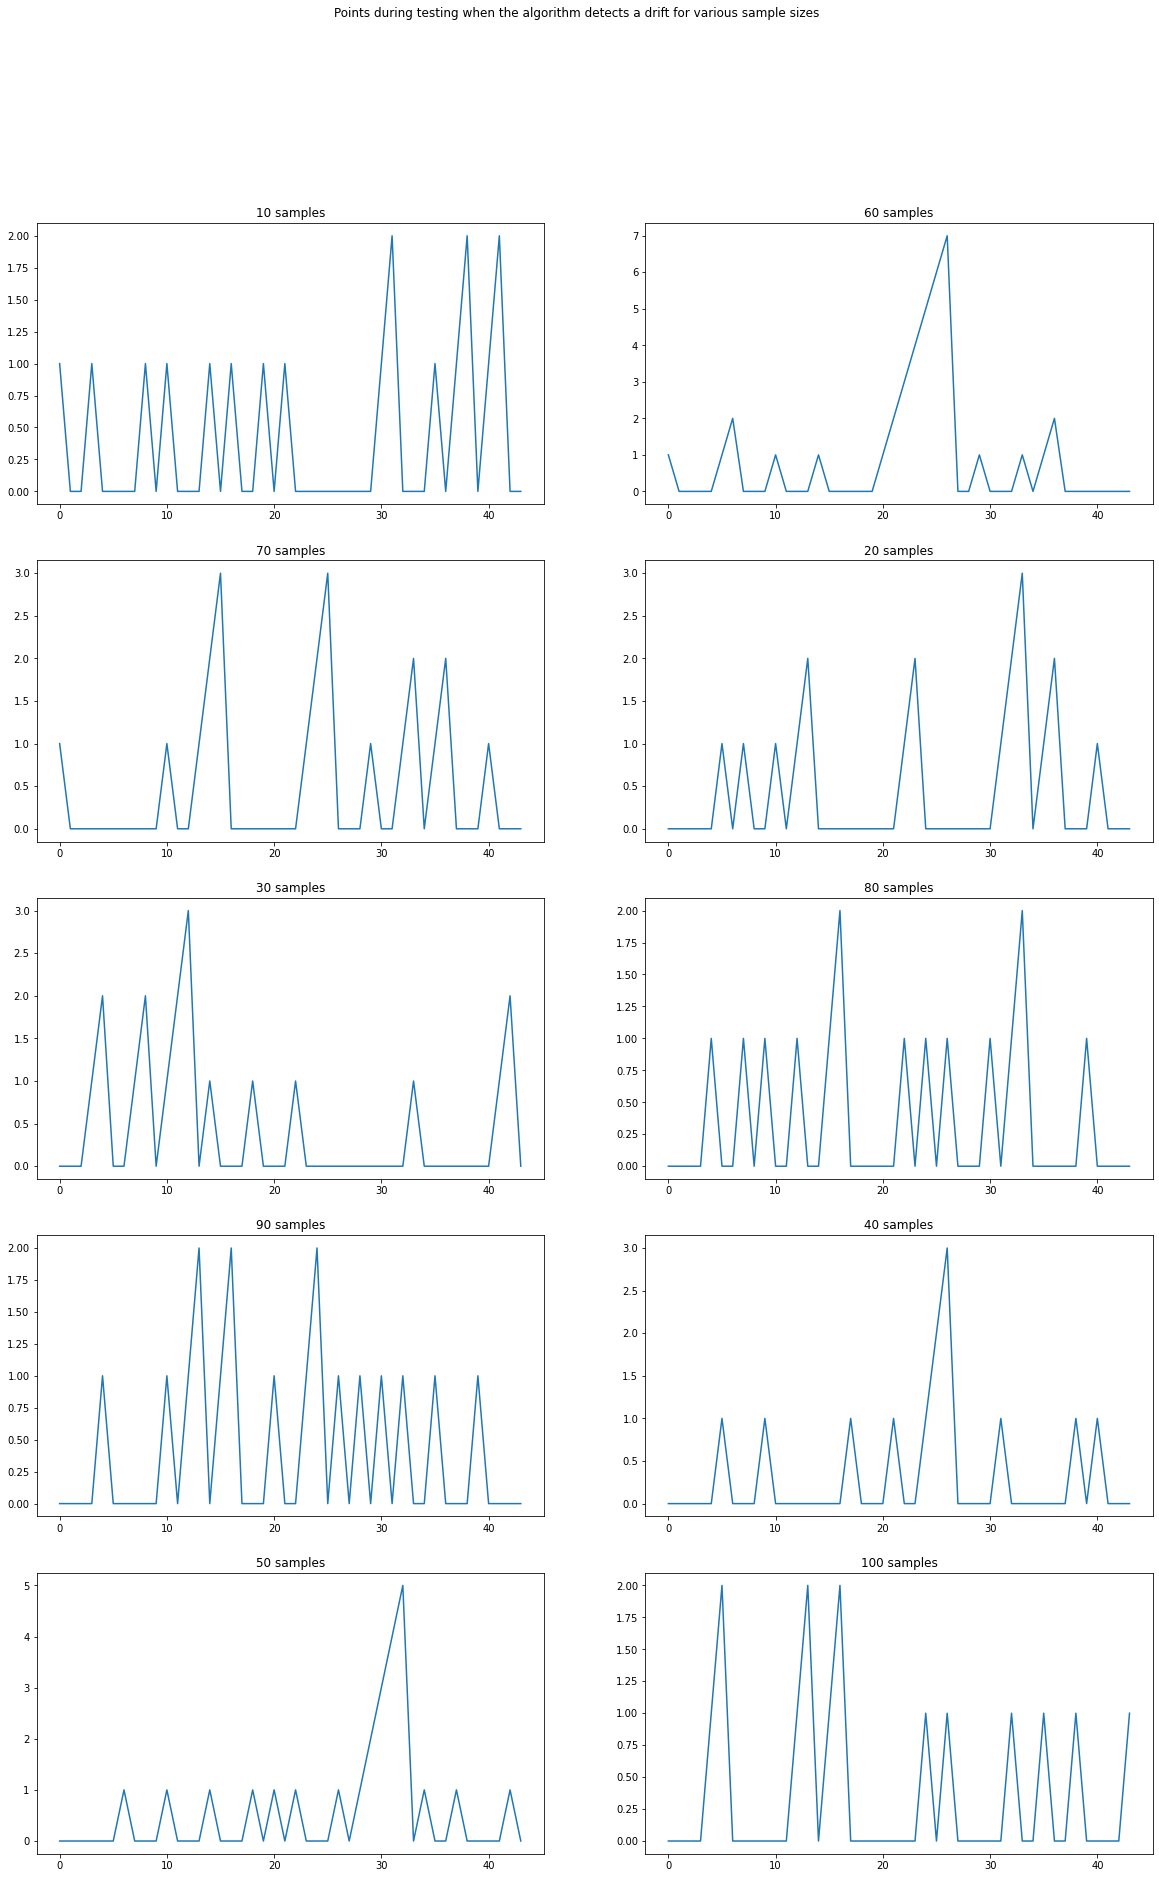

[26.468560867134247, 28.06315985973156, 28.713313059497754, 29.27617364854299, 29.89451356161825, 30.381659026274466, 30.951468262428417, 31.74615931629489, 32.4867626728778, 33.88613661369308]
[1.6618045258355614, 1.1050619002532127, 0.7686211923574047, 0.8588515283834959, 0.827370375994782, 0.8931749963729557, 0.9977407626883195, 0.9453481348381828, 1.0167225370242994, 1.3424973442474584]
[0.31820047437454974, 0.2734275433842532, 0.310278320529384, 0.322633580824674, 0.3412496565013503, 0.3399819481689709, 0.35071116290060017, 0.3365691355729783, 0.3288614994073108, 0.3023853213662775]
[0.1865290390091392, 0.10949533979117325, 0.09189932789883982, 0.09453620095472835, 0.09178700882746615, 0.06506219795607703, 0.0703096959305834, 0.07106734634464831, 0.07131739612514126, 0.06435780829796942]
(87, 100)
test data size = 87


10it [00:36,  3.66s/it]


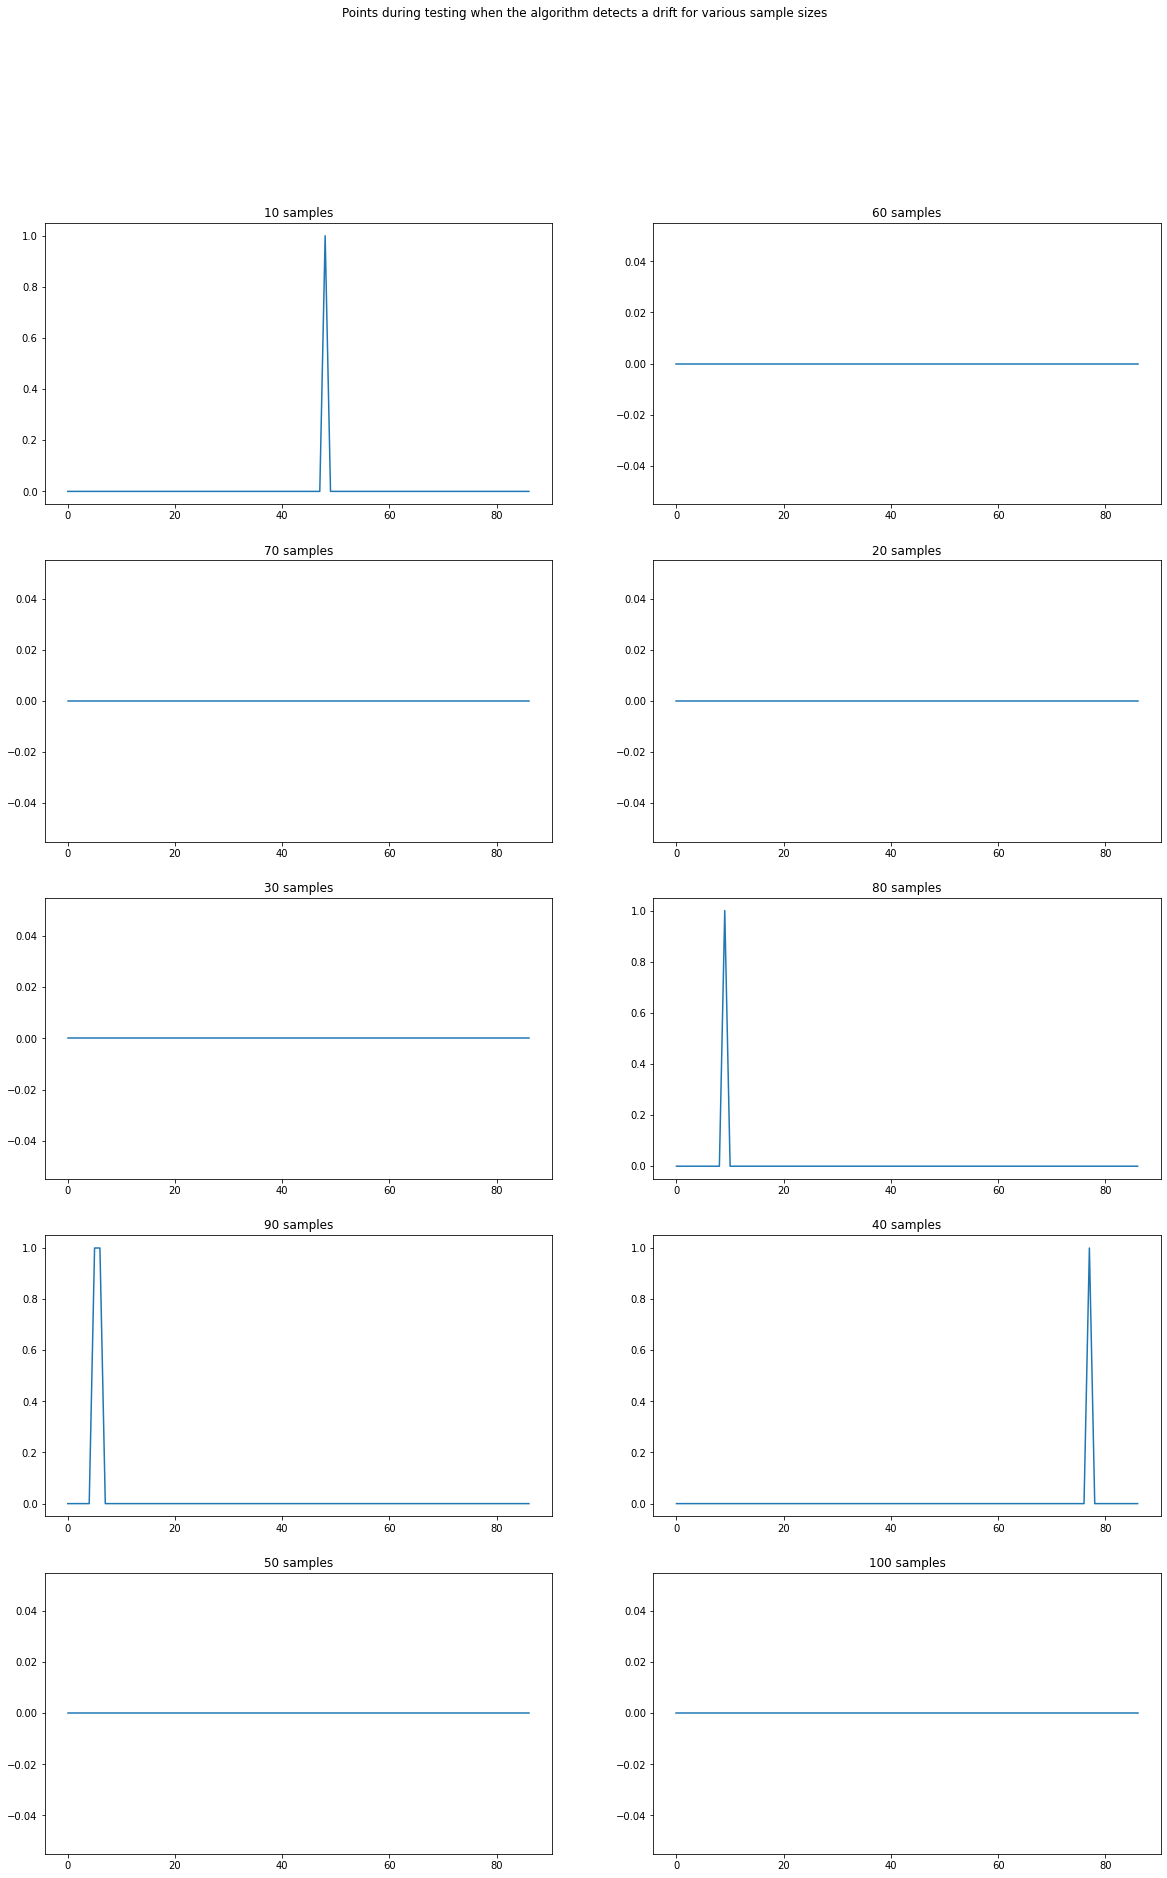

[25.627246571062727, 28.394427913620746, 29.281833845289754, 29.947070458387063, 30.5473875629601, 31.145863037600378, 31.81653923579342, 32.492384837417625, 33.52819514540819, 35.024017760513175]
[2.3978459662077425, 1.1851429137294625, 0.9452566332666804, 0.8385175752748218, 0.9445196212918165, 1.0542670603524857, 1.009055245233779, 1.0545294898944046, 1.2544147136222068, 1.4515937755724555]
[0.4509481760286148, 0.28234600788780617, 0.3253054620902142, 0.34439522194014927, 0.3626768967860566, 0.3554261912322841, 0.3682379683379195, 0.36961666797727777, 0.3396918908868162, 0.30614550945517377]
[0.29045064795447373, 0.11401214217217842, 0.08937294612234918, 0.09486132315194726, 0.09688625543004159, 0.0906277241366257, 0.07719122920194994, 0.07273734555346258, 0.07018134530484532, 0.07564950831498837]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
I

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


[28.652207557531334, 29.390786657335948, 30.179446272104453, 30.736592628827815, 31.1428386289056, 31.745994627256778, 32.44644770276135, 33.169758396001, 34.19696021885921, 35.70002520121312]
[0.9194517712017343, 0.8829974427946863, 0.69580246829442, 0.7517987141287017, 0.779569197771021, 0.790232800293998, 0.877474523269085, 0.9057270625105832, 0.9792415189000423, 1.286991050214027]
[0.18916055370443027, 0.2816173154002762, 0.2919059074301042, 0.3124859862638931, 0.3421169833314531, 0.33641690480745734, 0.36428160792391234, 0.350373428220019, 0.33896557378875736, 0.30179213603480654]
[0.09460990805436933, 0.09711709332232908, 0.0896667660217022, 0.09896330815416382, 0.07924452060153508, 0.07443906679814483, 0.07404076252609339, 0.06718457967569062, 0.06986513495355108, 0.05900490900797479]


10it [00:26,  2.61s/it]


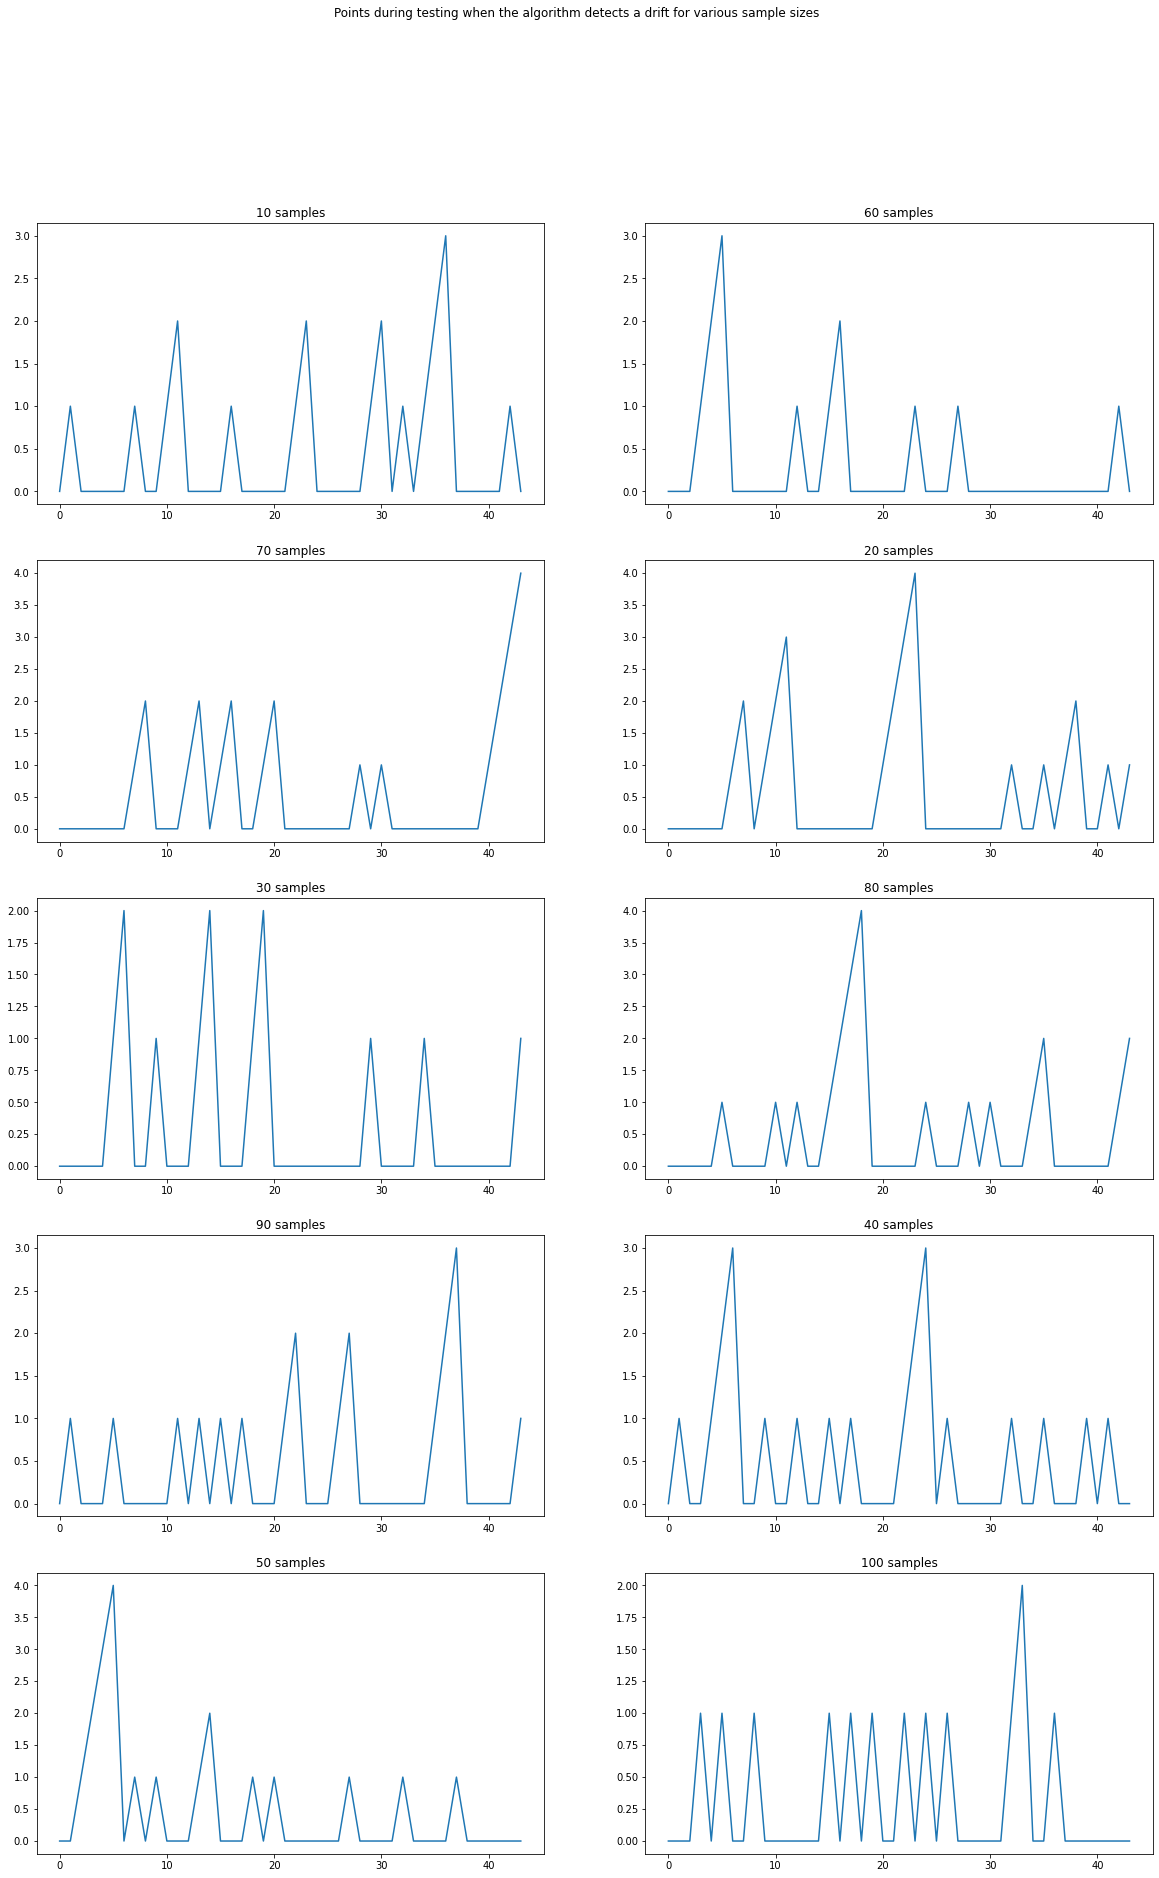

[28.652207557531334, 29.390786657335948, 30.179446272104453, 30.736592628827815, 31.1428386289056, 31.745994627256778, 32.44644770276135, 33.169758396001, 34.19696021885921, 35.70002520121312]
[0.9194517712017343, 0.8829974427946863, 0.69580246829442, 0.7517987141287017, 0.779569197771021, 0.790232800293998, 0.877474523269085, 0.9057270625105832, 0.9792415189000423, 1.286991050214027]
[0.18916055370443027, 0.2816173154002762, 0.2919059074301042, 0.3124859862638931, 0.3421169833314531, 0.33641690480745734, 0.36428160792391234, 0.350373428220019, 0.33896557378875736, 0.30179213603480654]
[0.09460990805436933, 0.09711709332232908, 0.0896667660217022, 0.09896330815416382, 0.07924452060153508, 0.07443906679814483, 0.07404076252609339, 0.06718457967569062, 0.06986513495355108, 0.05900490900797479]
(87, 100)
test data size = 87


10it [00:37,  3.72s/it]


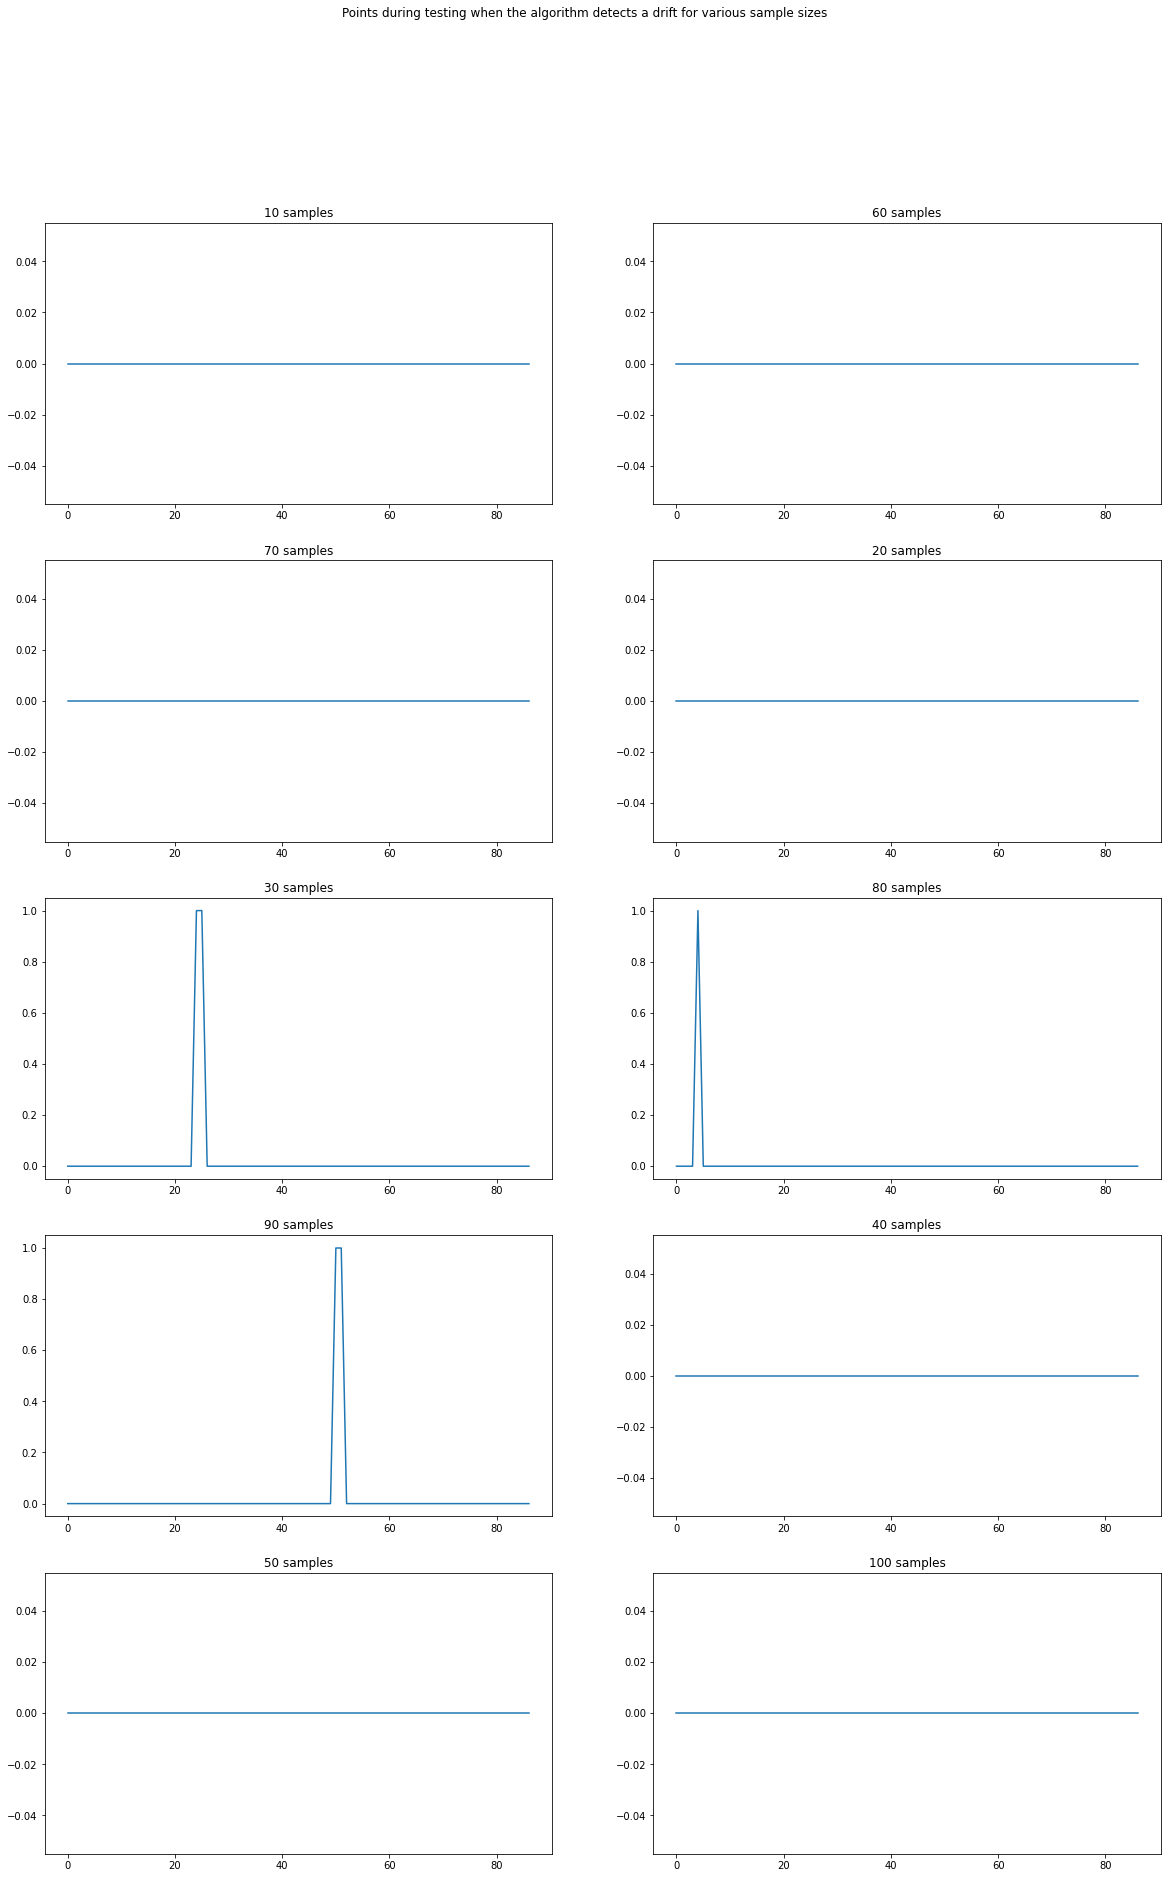

[26.94548141749488, 27.965577235629862, 28.926868401519762, 29.547147520511338, 30.005574500570194, 30.581882310993755, 31.239424383999506, 32.0378576905148, 32.90385973521035, 34.51015218866277]
[1.293119769288026, 1.0173770552046104, 0.810031858313225, 0.9129016712001586, 0.964004812467935, 1.020020054442449, 1.0627522832674785, 1.1148531810156002, 1.2332958825513851, 1.5220557350246353]
[0.20771545058831622, 0.2727286990302926, 0.3120394005316786, 0.31736534417691686, 0.3362938383833267, 0.3536577041500368, 0.37169104243495704, 0.3543060044112111, 0.3521785938877994, 0.3074402057420888]
[0.11641062561708093, 0.10455089273530795, 0.09608789865356411, 0.10174538273056696, 0.07688933283158876, 0.08048842192491125, 0.08792497640221332, 0.06941416012620791, 0.06726421192666063, 0.0764777041546841]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initia

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


[27.79055684466634, 29.360256430781657, 29.982881973769306, 30.46922963406104, 31.118012210054825, 31.533780324688244, 32.16355325597267, 32.99733791658688, 34.12836401923724, 35.36129870899524]
[1.5676839354991536, 0.8481109210671784, 0.7234635011426971, 0.8115178618239678, 0.8170560905868327, 0.7810592648153385, 0.9093163683509574, 1.0716705817071595, 1.2358494154229376, 1.3740396432518769]
[0.2069377240784904, 0.25167128797355726, 0.27345277686264047, 0.3120063414633074, 0.31685093750561094, 0.35054443995041173, 0.3442728990165159, 0.348349419355031, 0.33546446401912483, 0.3089813110612424]
[0.10720897971637967, 0.08787913864000216, 0.08327527388658275, 0.09254379289299716, 0.0622229251267441, 0.09274066528887057, 0.08313509269121137, 0.08408891805292457, 0.06708499013442605, 0.06180760190277198]


10it [00:26,  2.67s/it]


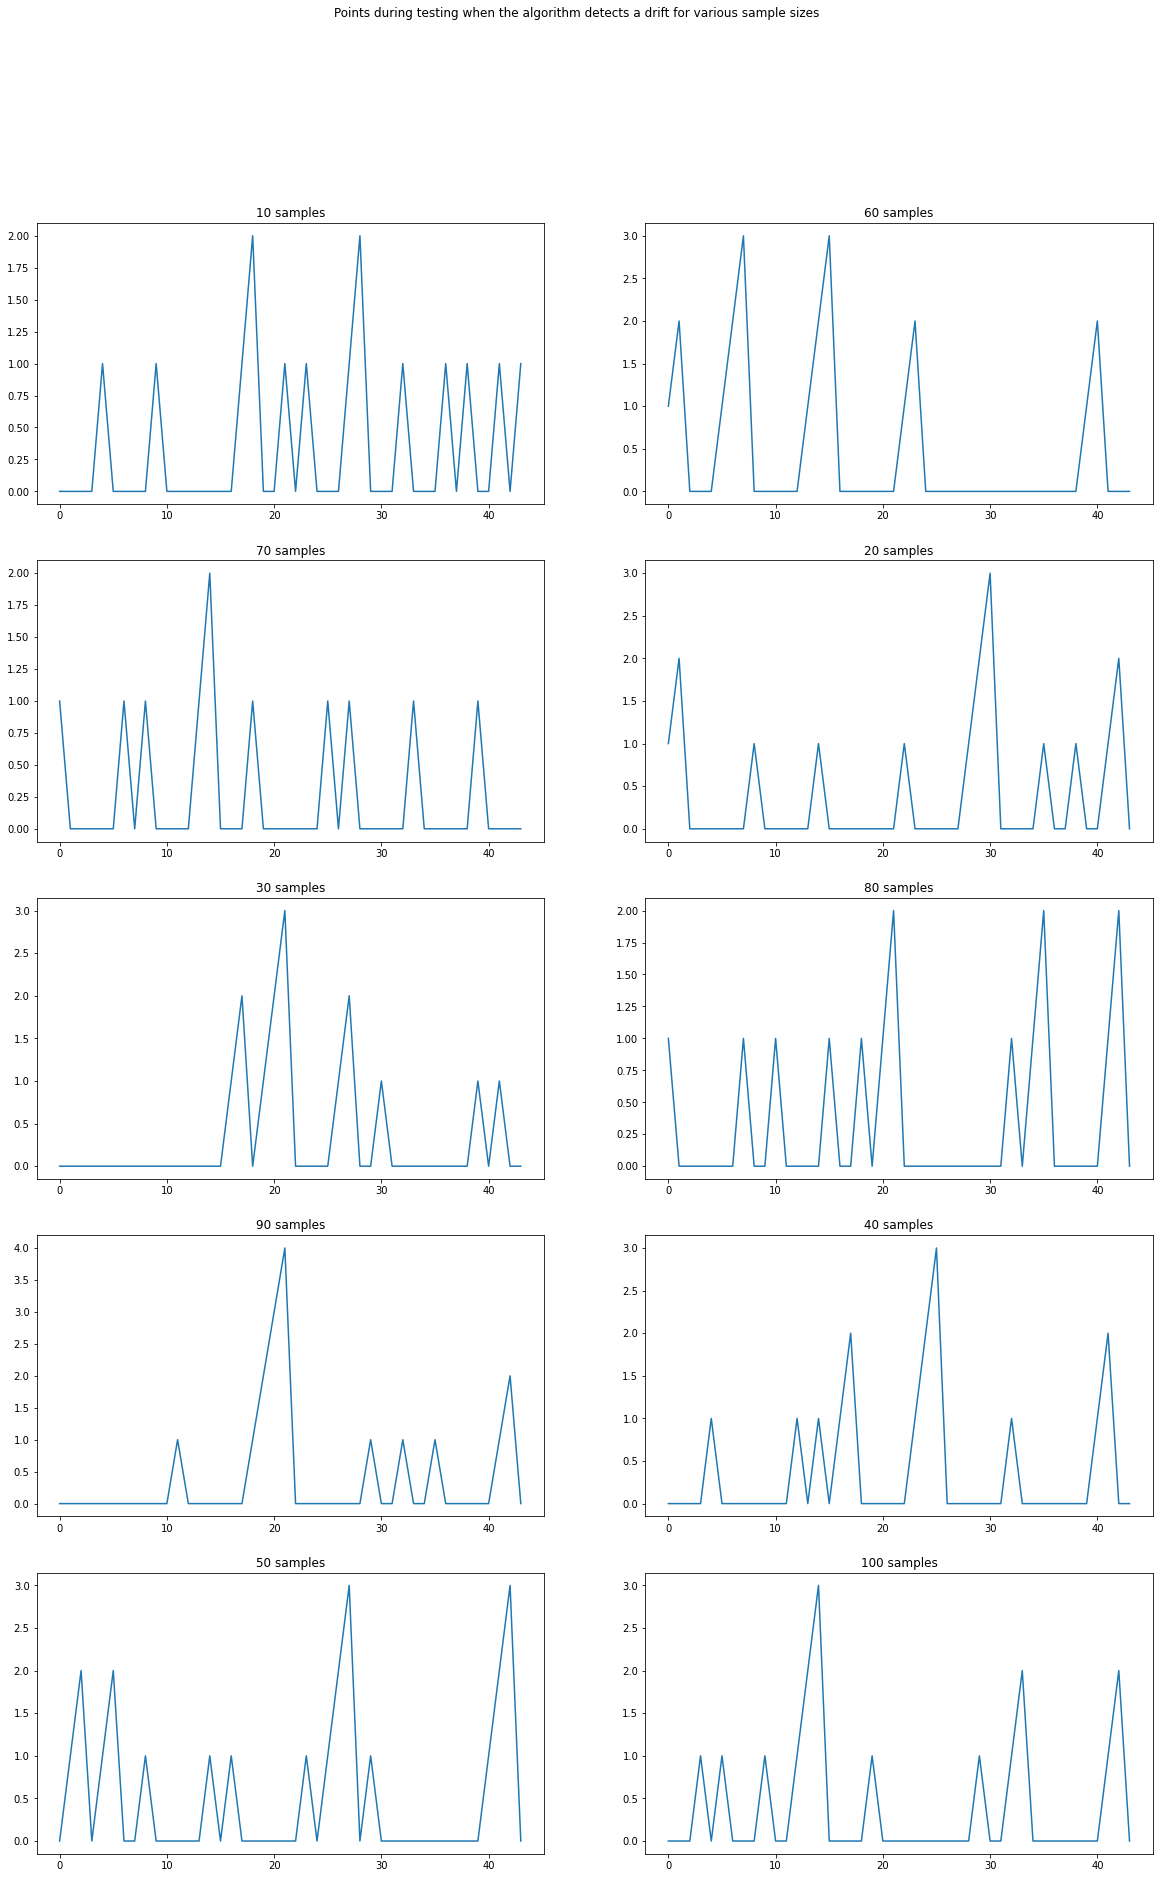

[27.79055684466634, 29.360256430781657, 29.982881973769306, 30.46922963406104, 31.118012210054825, 31.533780324688244, 32.16355325597267, 32.99733791658688, 34.12836401923724, 35.36129870899524]
[1.5676839354991536, 0.8481109210671784, 0.7234635011426971, 0.8115178618239678, 0.8170560905868327, 0.7810592648153385, 0.9093163683509574, 1.0716705817071595, 1.2358494154229376, 1.3740396432518769]
[0.2069377240784904, 0.25167128797355726, 0.27345277686264047, 0.3120063414633074, 0.31685093750561094, 0.35054443995041173, 0.3442728990165159, 0.348349419355031, 0.33546446401912483, 0.3089813110612424]
[0.10720897971637967, 0.08787913864000216, 0.08327527388658275, 0.09254379289299716, 0.0622229251267441, 0.09274066528887057, 0.08313509269121137, 0.08408891805292457, 0.06708499013442605, 0.06180760190277198]
(87, 100)
test data size = 87


10it [00:37,  3.74s/it]


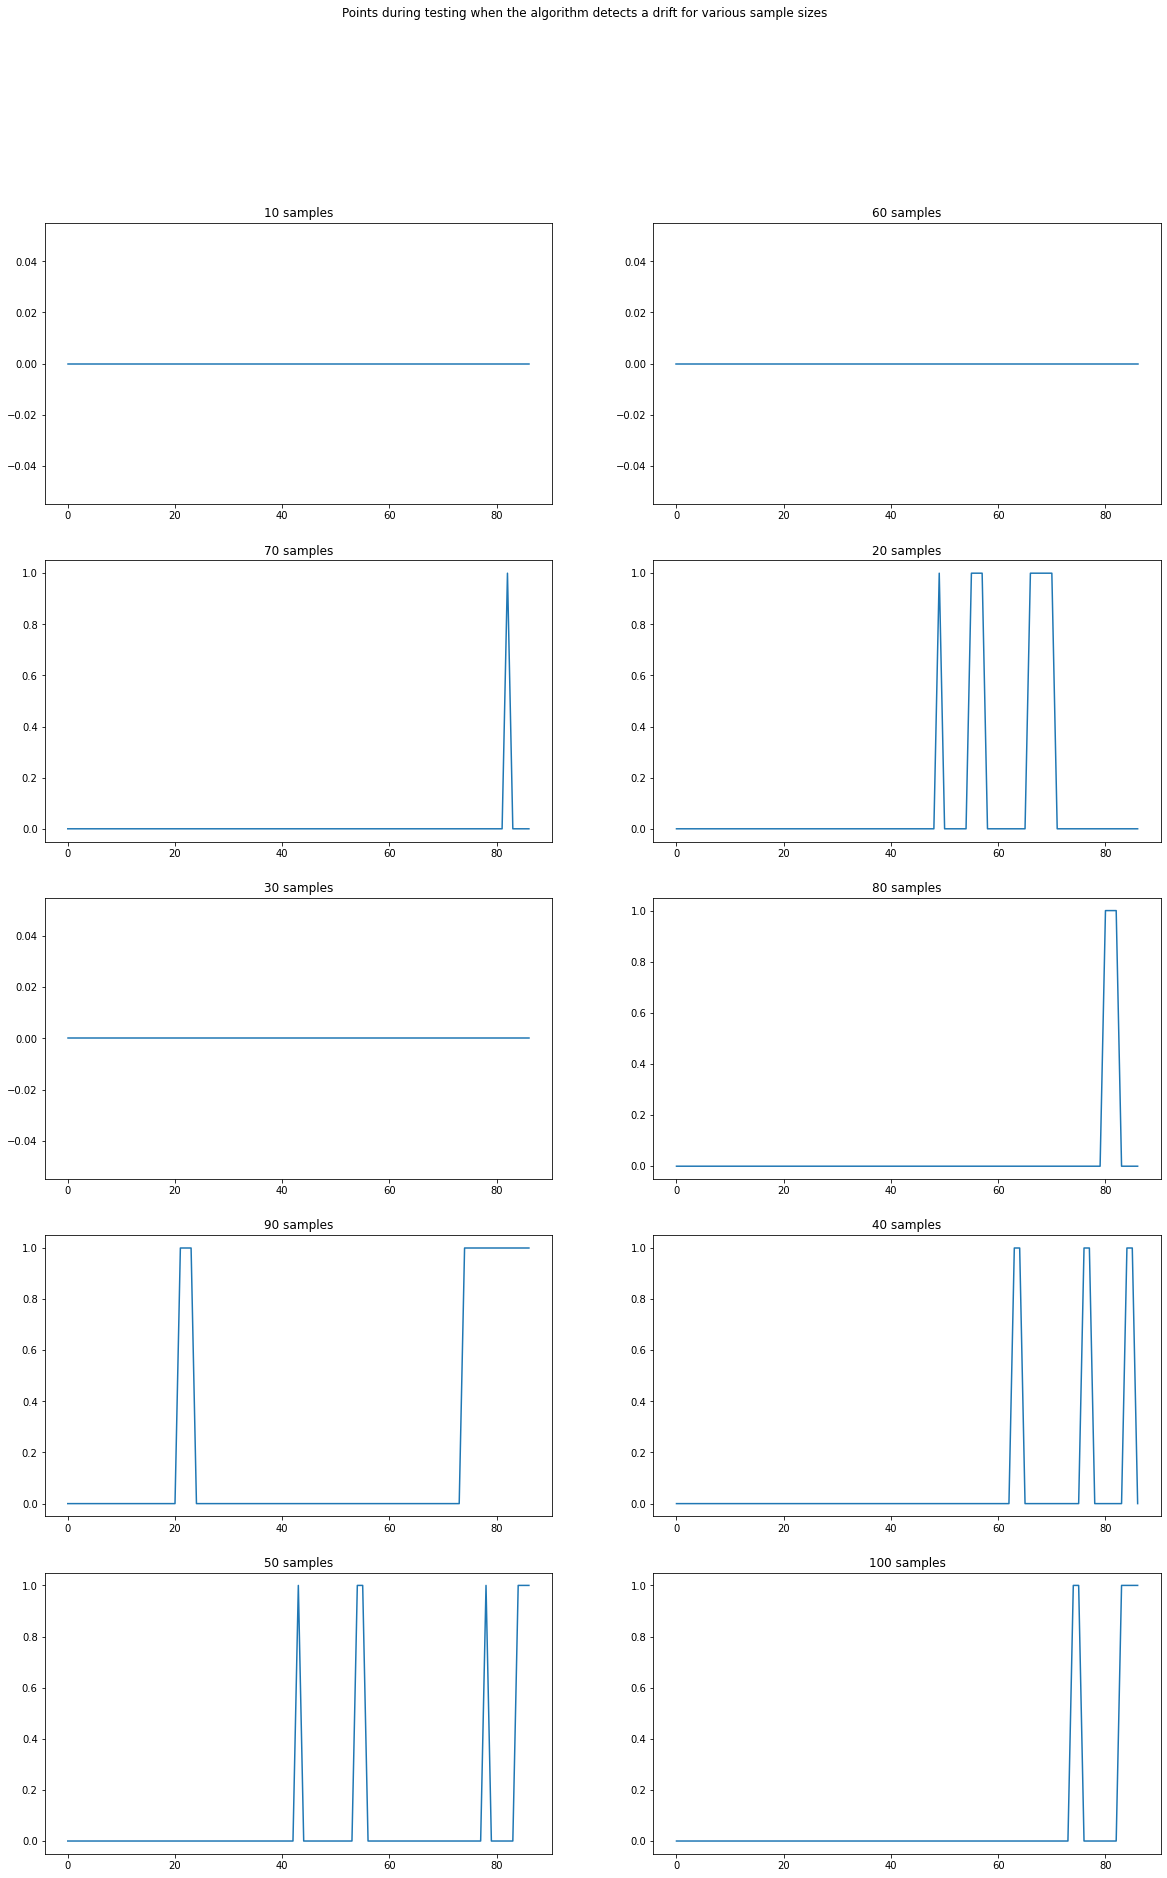

[23.75532579989374, 26.249027967807006, 27.407992604183253, 28.07192166838949, 28.719143337308804, 29.32926163505754, 30.17668846328215, 30.90226106727286, 31.77461620956103, 33.108747986010805]
[1.6264514528724858, 1.149806238882203, 0.9506937821515379, 0.8356922477097668, 0.9366917983496543, 0.8730687114806159, 0.9526035984223747, 1.1122212498433472, 1.2634363286096038, 1.3434647554076702]
[0.2320690012916745, 0.36658024930339034, 0.3216977390780627, 0.36893987528495464, 0.3865304765332849, 0.4019353494121439, 0.37167956426150717, 0.39078844184022954, 0.3893839953287758, 0.36847309083695545]
[0.11838110255577729, 0.1291934089990125, 0.09468931597014386, 0.07801458129316514, 0.08906207003841031, 0.09104736937367075, 0.08128537979823065, 0.0879185785396718, 0.08140068395798507, 0.07943282308323364]


In [52]:
import pandas as pd

fig, ax = plt.subplots(len(paths_1)//2, 2, figsize = (15, 25))
fig.suptitle("Plots of response under standard conditions")
for i,path in enumerate(paths_1):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["input"])
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["output"])
    ax[i%(len(paths_1)//2)][i%2].set_title(path[-14:-8])

plt.show()

fig, ax = plt.subplots(len(paths_2)//2, 2, figsize = (15, 25))
fig.suptitle("Plots of response under rivet hole")
for i,path in enumerate(paths_2):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["input"])
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["output"])
    ax[i%(len(paths_1)//2)][i%2].set_title(path[-14:-8])

plt.show()


for i,path in enumerate(zip(paths_1, paths_2)):
    db = pd.read_csv(path[0], usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    model, n_train, test_data, A_, thresholds = train_GMM_to_data(db, int(path[0][-10:-8]), 100, 10, 5)
    reconstruct_test_data(model, A_, test_data, int(path[0][-10:-8]), 100, 10, n_train, thresholds, "clean")

    # generate test data
    db = pd.read_csv(path[1], usecols=[3,4,10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    rivet_test_data = get_rivet_data(db, int(path[1][-10:-8]), 100)
    reconstruct_test_data(model, A_, rivet_test_data, int(path[1][-10:-8]), 100, 10, n_train, thresholds, "rivet")